# Описание проекта

## Общие вводные

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо. 

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас. 

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся. 

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Задача — провести анализ и подготовить план действий по удержанию клиентов.  

### План действий

* Предобработать имеющиеся данные для удобства работы и провести их исследовательский анализ;
* Сформировать модель машинного обучения, которая будет прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства (провести кластеризацию);
* Проанализировать основные признаки, наиболее сильно влияющие на отток;
* Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

    1) выделить целевые группы клиентов;
    
    2) предложить меры по снижению оттока;
    
    3) определить другие особенности взаимодействия с клиентами.

### Описание данных

Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

* Данные клиента за предыдущий до проверки факта оттока месяц:
    * 'gender' — пол;
    * 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
    * 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
    * Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
    * 'Phone' — наличие контактного телефона;
    * 'Age' — возраст;
    * 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
* Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
    * 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
    * 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
    * 'Group_visits' — факт посещения групповых занятий;
    * 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
    * 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
    * 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* 'Churn' — факт оттока в текущем месяце.

# Загрузка и предобработка данных

Первым делом загрузим библиотеки, необходимые в работе, и прочитаем датасет.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import itertools
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('gym_churn.csv')
df.head(5)

gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0         3                   0.020398                           0.000000   
1         7                   1.922936                           1.910244   
2         2                   1.859098                           1.736502   
3         2                   3.205633                           3.357215   
4         3                   1.113884                           1.120078   

   Churn  
0      0  
1      0  
2      0  
3      0  
4      0

Приведем названия столбцов к единому виду со всеми строчными буквами.

In [3]:
df.columns = df.columns.str.lower()
df.head(5)

gender  near_location  partner  promo_friends  phone  contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   group_visits  age  avg_additional_charges_total  month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   lifetime  avg_class_frequency_total  avg_class_frequency_current_month  \
0         3                   0.020398                           0.000000   
1         7                   1.922936                           1.910244   
2         2                   1.859098                           1.736502   
3         2                   3.205633                           3.357215   
4         3                   1.113884                           1.120078   

   churn  
0      0  
1      0  
2      0  
3      0  
4      0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Рассмотрим встречающиеся в датафрейме значения по каждой колонке.

In [5]:
for col in df.columns:
    display(df[col].value_counts())

1    2041
0    1959
Name: gender, dtype: int64

1    3381
0     619
Name: near_location, dtype: int64

0    2053
1    1947
Name: partner, dtype: int64

0    2766
1    1234
Name: promo_friends, dtype: int64

1    3614
0     386
Name: phone, dtype: int64

1     2207
12     960
6      833
Name: contract_period, dtype: int64

0    2351
1    1649
Name: group_visits, dtype: int64

29    468
30    457
28    447
31    434
27    378
32    364
26    300
33    253
25    231
34    174
24    148
35     98
23     82
36     48
22     33
37     29
21     24
20     14
38     10
39      3
19      2
18      2
41      1
Name: age, dtype: int64

14.227470     1
17.082321     1
278.204461    1
120.457631    1
130.711299    1
             ..
92.329635     1
147.615388    1
24.923561     1
56.129880     1
178.861814    1
Name: avg_additional_charges_total, Length: 4000, dtype: int64

1.0     2207
6.0      645
12.0     524
11.0     181
5.0      130
10.0      82
9.0       73
4.0       58
8.0       38
7.0       25
3.0       23
2.0       14
Name: month_to_end_contract, dtype: int64

1     843
2     610
3     490
0     487
4     383
5     273
6     220
7     167
8     111
9     100
10     76
12     53
11     48
13     28
15     24
14     24
16     15
17     11
20      7
19      7
18      7
21      5
23      2
24      2
26      2
22      2
31      1
27      1
29      1
Name: lifetime, dtype: int64

0.000000    88
0.020398     1
2.182034     1
1.976985     1
1.671952     1
            ..
0.999179     1
1.734371     1
1.783444     1
3.791391     1
1.101832     1
Name: avg_class_frequency_total, Length: 3913, dtype: int64

0.000000    181
1.328134      1
2.628932      1
1.797684      1
1.524367      1
           ... 
2.359231      1
2.461782      1
0.671450      1
1.047047      1
1.035270      1
Name: avg_class_frequency_current_month, Length: 3820, dtype: int64

0    2939
1    1061
Name: churn, dtype: int64

По общей информации видно, что в категориальных значениях нет нехарактерных для условий задания значений, целочисленные значения встречаются там, где по логике вещей они и должны быть, дробные значения - аналогично.

Теперь посмотрим, есть ли в данных пропуски.

In [6]:
df.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

<AxesSubplot:>

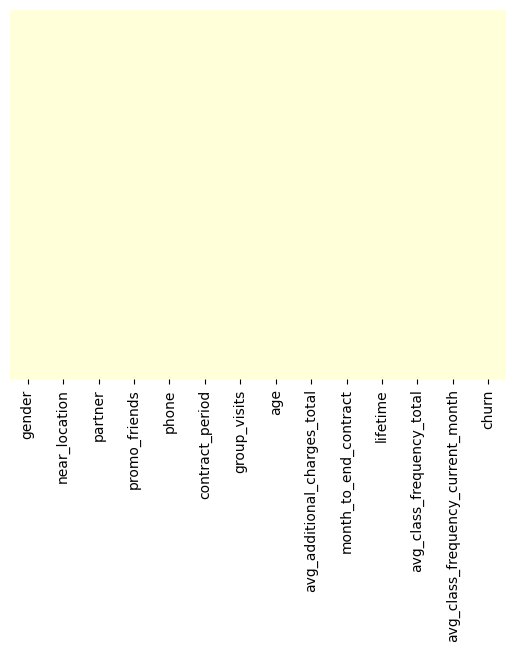

In [7]:
sns.heatmap(df.isna(), yticklabels=False, cbar=False, cmap="YlGnBu")

Пропуски в данных отсутствуют. Это значит, что, как минимум, данные были собраны качественно и нет необходимости заполнять пропуски теми или иными значениями, определенными на основе медиан, средних и т.п.

**Выводы**

Нам достался достаточно качественно собранный набор данных, с которым можно проводить различные манипуляции, не тратя время на его доработку. Поэтому приступим к исследовательскому анализу и далее по намеченным выше целям и этапам работы.

# Исследовательский анализ данных (EDA)

## Общее описание данных

### Распределение показателей

Первым делом изучим распределение значений по столбцам датасета.

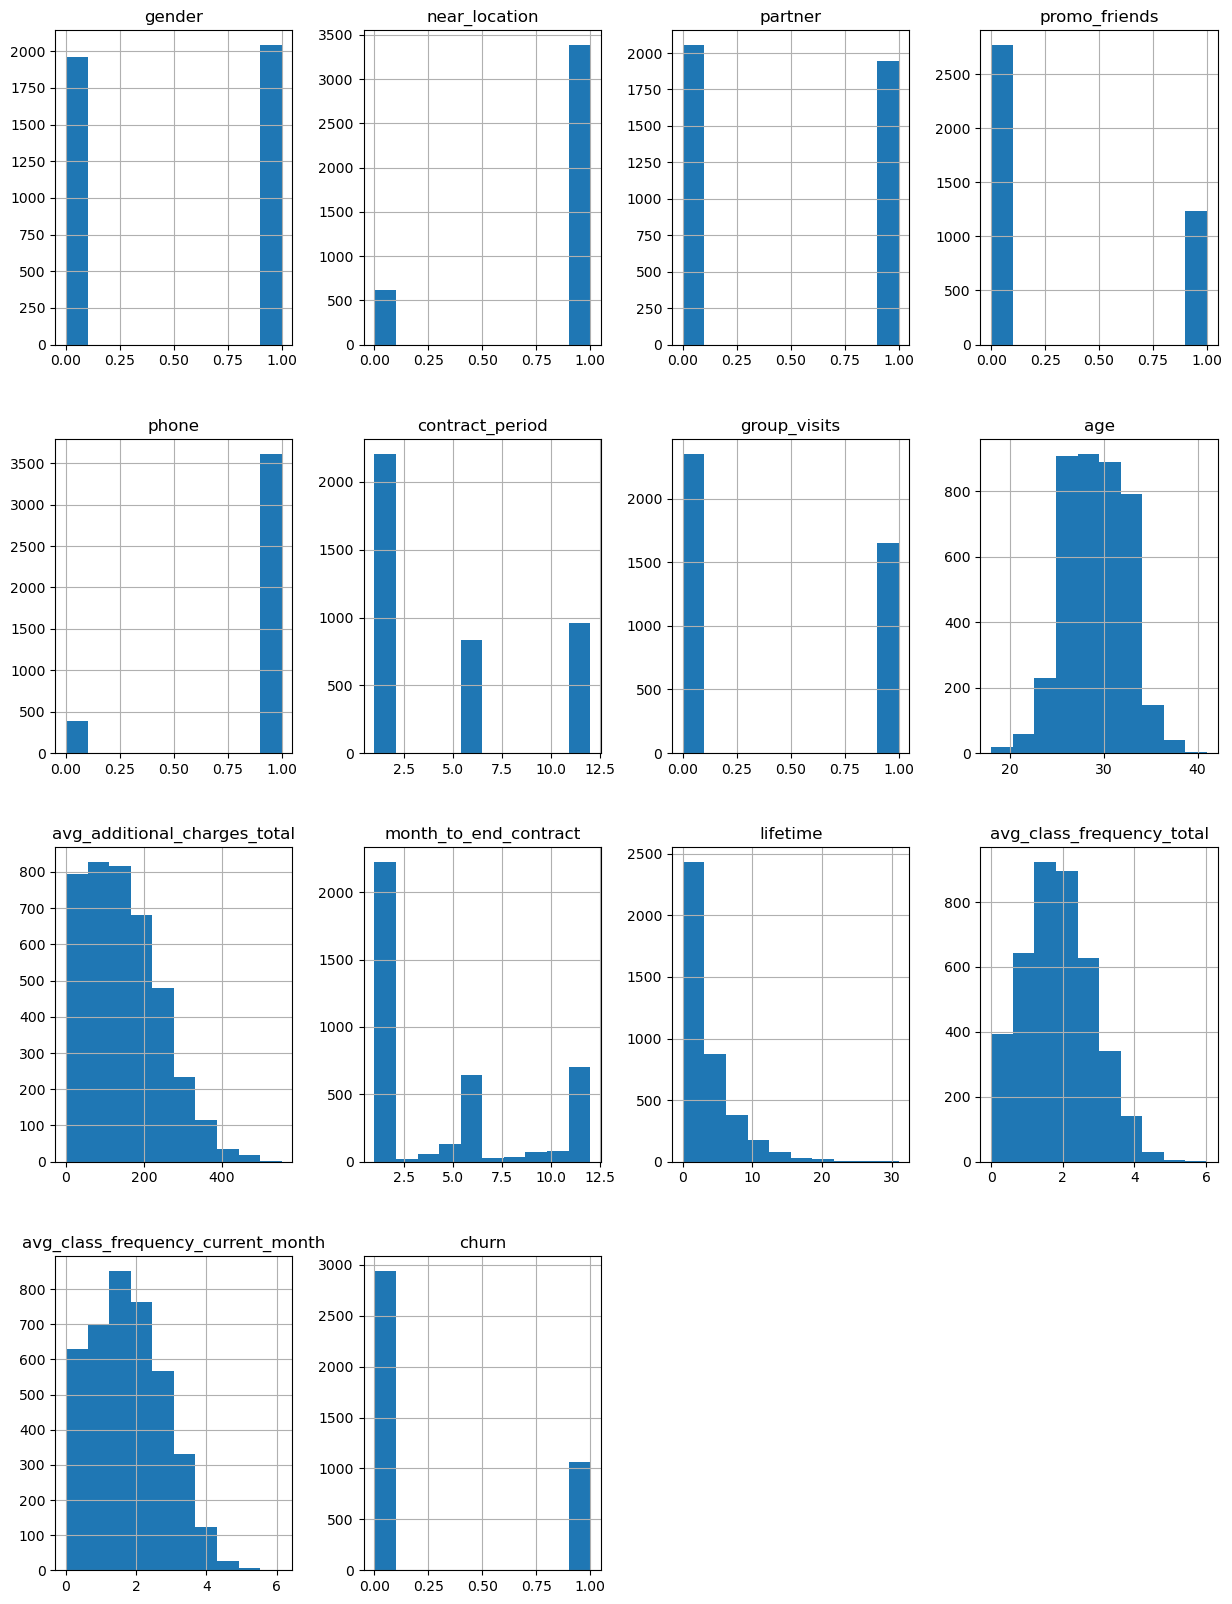

In [8]:
df.hist(figsize=(15, 20))
plt.show()

Также изучим общую информацию по данным и основные статистические показатели.

In [9]:
df.describe()

gender  near_location      partner  promo_friends        phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       contract_period  group_visits          age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.000000    27.000000   
50%           1.000000      0.000000    29.000000   
75%           6.000000      1.000000    31.000000   
max          12.000000      1.000000    41.000000   

       avg_additional_charges_total  month_to_end_contract     lifetime  \
count                   4000.000000            4000.000000  4000.000000   
mean                     146.943728               4.322750     3.724750   
std                       96.355602               4.191297     3.749267   
min                        0.148205               1.000000     0.000000   
25%                       68.868830               1.000000     1.000000   
50%                      136.220159               1.000000     3.000000   
75%                      210.949625               6.000000     5.000000   
max                      552.590740              12.000000    31.000000   

       avg_class_frequency_total  avg_class_frequency_current_month  \
count                4000.000000                        4000.000000   
mean                    1.879020                           1.767052   
std                     0.972245                           1.052906   
min                     0.000000                           0.000000   
25%                     1.180875                           0.963003   
50%                     1.832768                           1.719574   
75%                     2.536078                           2.510336   
max                     6.023668                           6.146783   

             churn  
count  4000.000000  
mean      0.265250  
std       0.441521  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

Категориальные переменные принимают логичные значения 0 и 1 как минимумы и максимумы. Возраст посетителей варьируется от 18 до 41 года (среднее 29.18), срок абонемента - от 1 месяца до 12 (среднее 4.68), средняя выручка от дополнительных услуг варьируется от 0.14 до 552.59 (среднее 146.94), срок жизни клиентов - от 0 до 31 месяца (среднее 3.72), средняя частота посещений в месяц - от 0 до 6.023 (среднее 1.87), средняя общая частота посещений - от 0 до 6.14 (средне 1.76). 

В целом, с такими данными можно работать и уже по ним можно сделать общие выводы о посетителях фитнес-клуба. И, как минимум, не особо положительно их вовлеченность в спорт характеризуется тем, что в среднем в месяц люди посещают клуб чуть более одного раза. Однако, средний "срок жизни" в 3.72 месяца может быть одной из причин такой малой средней посещаемости для пользователей в общем.

### Взаимосвязь показателей и корреляционная матрица

Построим корреляционную матрицу по столбцам датафрейма и визуализируем ее.

gender  near_location   partner  \
gender                             1.000000       0.006699 -0.010463   
near_location                      0.006699       1.000000 -0.005119   
partner                           -0.010463      -0.005119  1.000000   
promo_friends                     -0.005033       0.210964  0.451960   
phone                             -0.008542      -0.015763  0.009970   
contract_period                    0.000502       0.150233  0.306166   
group_visits                       0.017879       0.154728  0.022710   
age                                0.013807       0.058358  0.047480   
avg_additional_charges_total      -0.009334       0.040761  0.022941   
month_to_end_contract             -0.001281       0.143961  0.294632   
lifetime                           0.013579       0.070921  0.061229   
avg_class_frequency_total          0.014620       0.043127  0.024938   
avg_class_frequency_current_month  0.009156       0.062664  0.045561   
churn                              0.000708      -0.128098 -0.157986   

                                   promo_friends     phone  contract_period  \
gender                                 -0.005033 -0.008542         0.000502   
near_location                           0.210964 -0.015763         0.150233   
partner                                 0.451960  0.009970         0.306166   
promo_friends                           1.000000  0.001982         0.244552   
phone                                   0.001982  1.000000        -0.006893   
contract_period                         0.244552 -0.006893         1.000000   
group_visits                            0.120170 -0.010099         0.169991   
age                                     0.050113 -0.011403         0.138249   
avg_additional_charges_total            0.036898  0.009279         0.111445   
month_to_end_contract                   0.239553 -0.011196         0.973064   
lifetime                                0.072721 -0.018801         0.170725   
avg_class_frequency_total               0.028063  0.008340         0.096211   
avg_class_frequency_current_month       0.053768  0.013375         0.159407   
churn                                  -0.162233 -0.001177        -0.389984   

                                   group_visits       age  \
gender                                 0.017879  0.013807   
near_location                          0.154728  0.058358   
partner                                0.022710  0.047480   
promo_friends                          0.120170  0.050113   
phone                                 -0.010099 -0.011403   
contract_period                        0.169991  0.138249   
group_visits                           1.000000  0.080934   
age                                    0.080934  1.000000   
avg_additional_charges_total           0.032079  0.080240   
month_to_end_contract                  0.163703  0.134511   
lifetime                               0.075853  0.164693   
avg_class_frequency_total              0.056695  0.119953   
avg_class_frequency_current_month      0.075923  0.183095   
churn                                 -0.175325 -0.404735   

                                   avg_additional_charges_total  \
gender                                                -0.009334   
near_location                                          0.040761   
partner                                                0.022941   
promo_friends                                          0.036898   
phone                                                  0.009279   
contract_period                                        0.111445   
group_visits                                           0.032079   
age                                                    0.080240   
avg_additional_charges_total                           1.000000   
month_to_end_contract                                  0.113958   
lifetime                                               0.079028   
avg_class_frequency_total                         

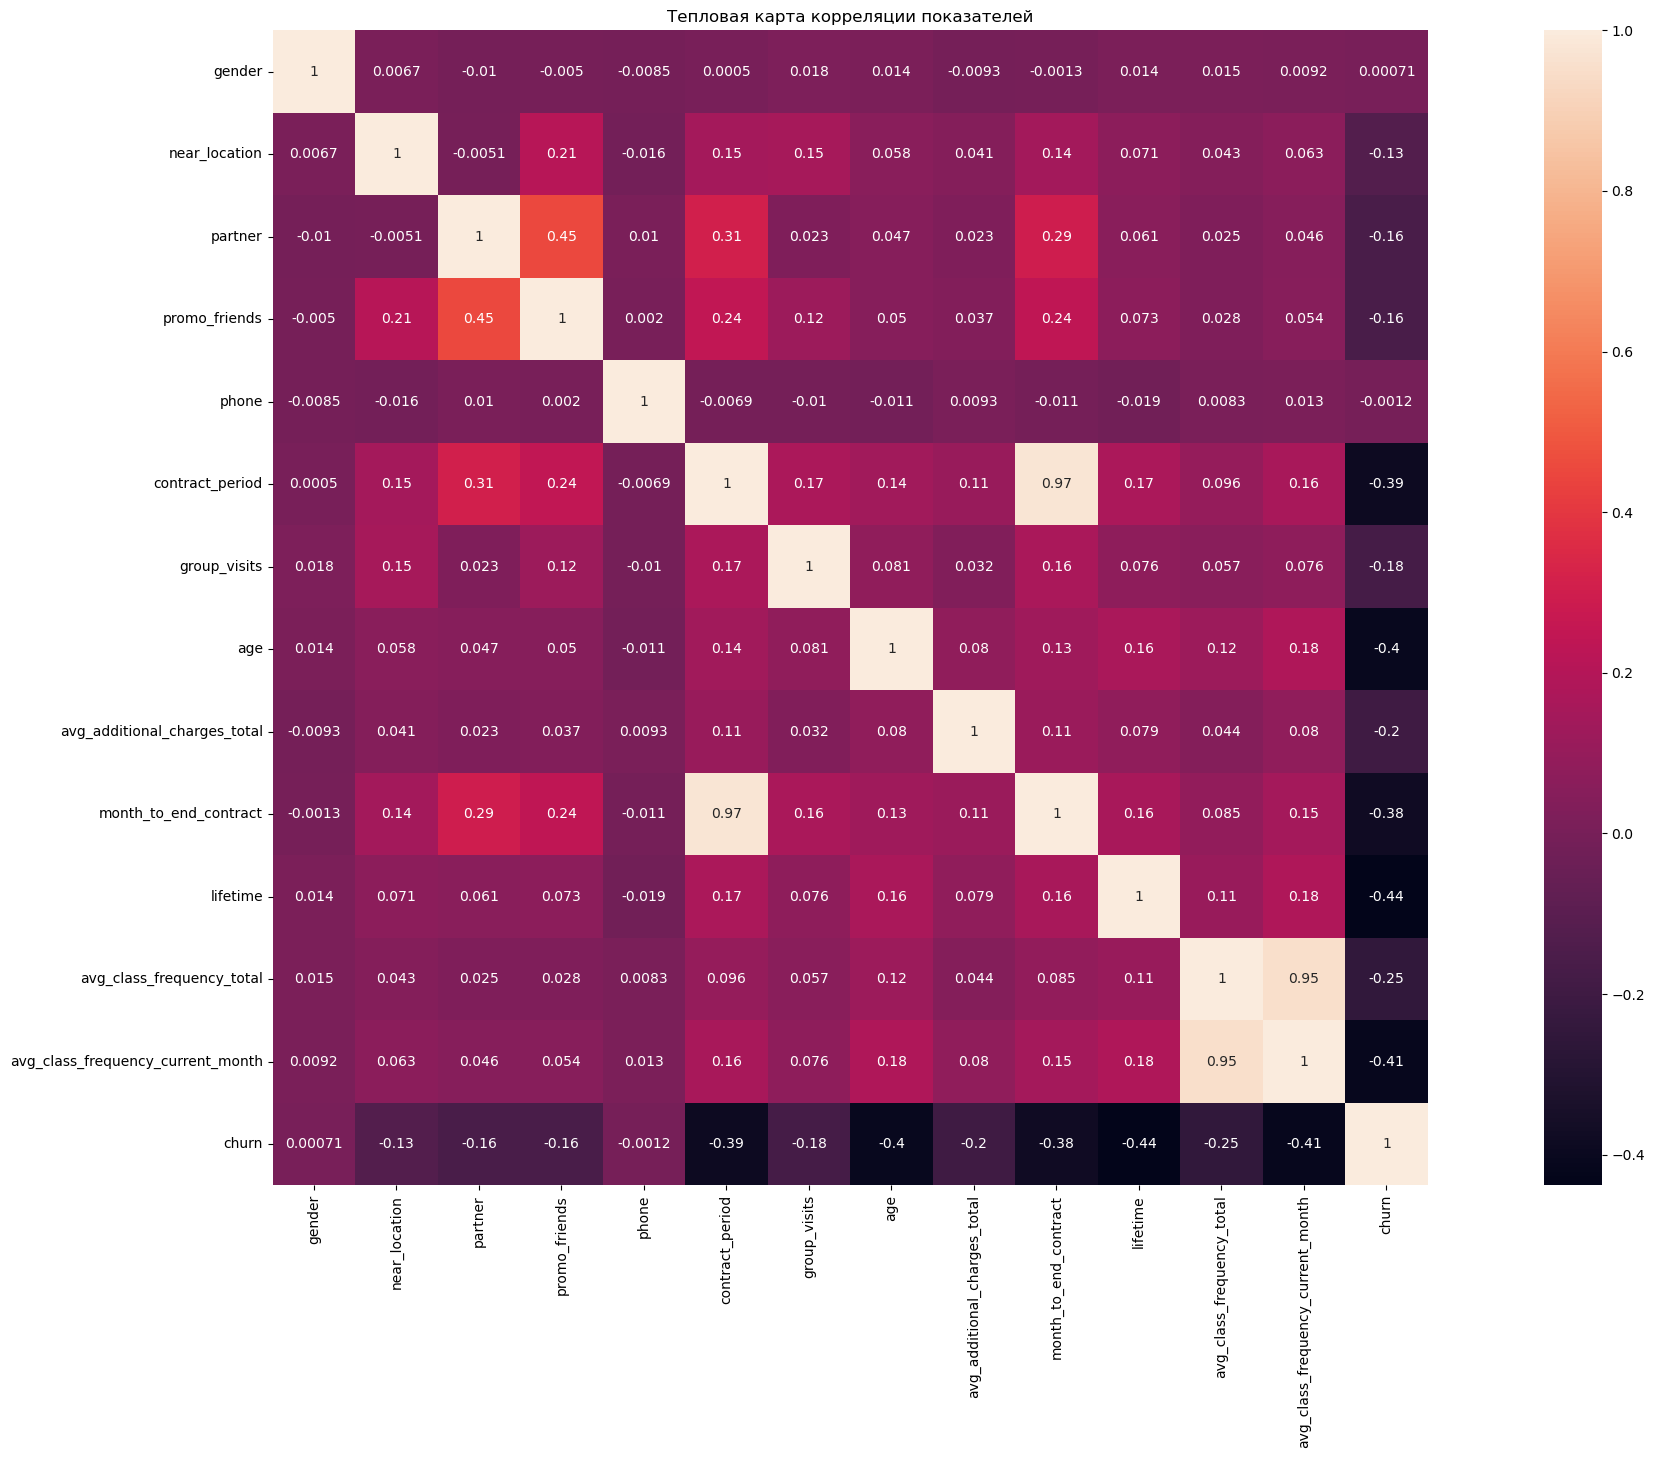

In [10]:
cm = df.corr() #вычисляем матрицу корреляций
display(cm)
plt.figure(figsize=(30,15))
#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm,annot=True, square=True)
plt.title('Тепловая карта корреляции показателей')
plt.show()

Интересно обратить внимание на то, что показатель оттока практически везде имеет отрицательную корреляцию с остальными колонками.

При этом, высокая корреляция наблюдается у показателей, связанных с партнерством (предоставлением партнерских промо-кодов) и акцией "приведи друга", также достаточно явная зависимость между сроком контракта и участием в партнерских и промо-программах. Можно предположить, что данные факторы взаимозависимы, и партнерские программы могут иметь определеные параметры: скидки по промо-кодам на контракты с фиксированным/длительным сроком действия и т.д.

Наибольшая же корреляция замечена между средней частотой посещений в месяц и средней частотой посещений за все время действия абонемента. Эта взаимосвязь максимально логична: чем чаще человек посещает клуб в месяц, тем выше будет у него частота посещений клуба за все время действия абонемента.

### Попарная зависимость показателей и целевой переменной

В нашем исследовании целевая переменная - это отток клиента (принимает значения 0 - "нет оттока" и 1 - "есть отток"), поэтому в рамках исследования взаимозависимости изучим как каждый показатель кроме целевого взаимодействует с целевым.

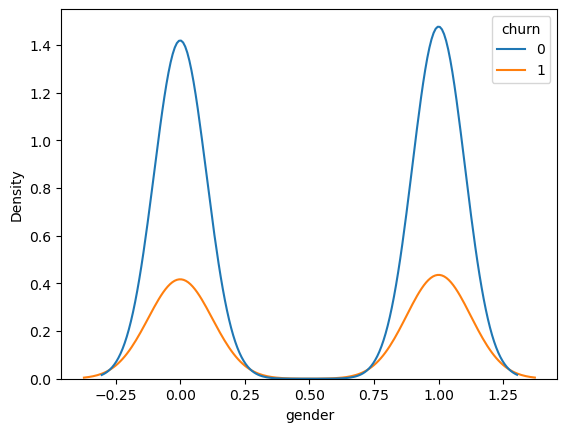

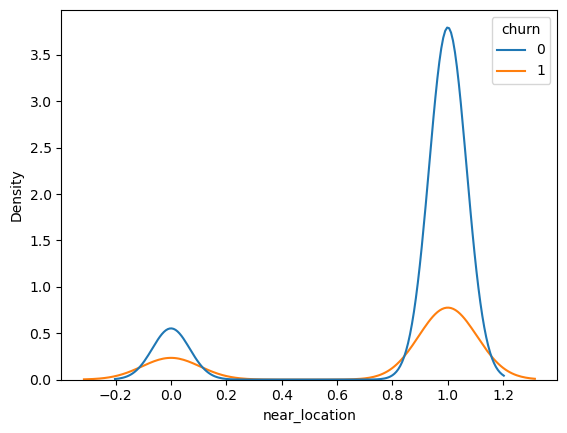

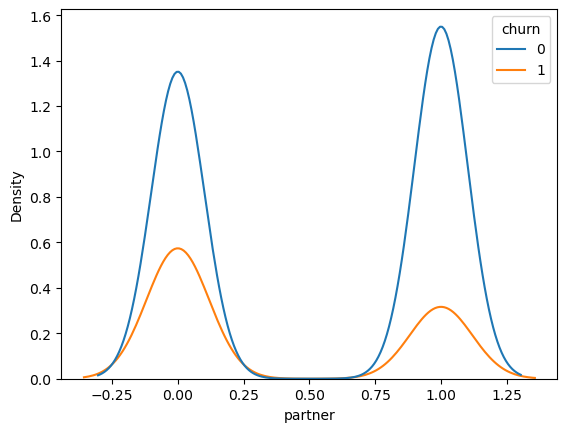

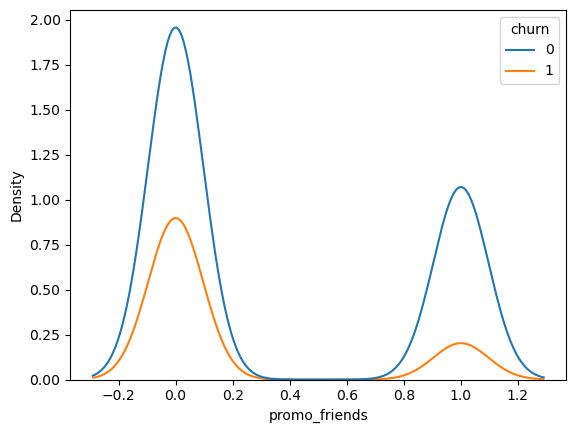

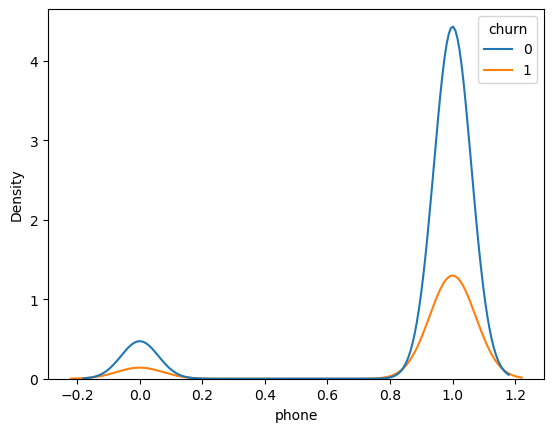

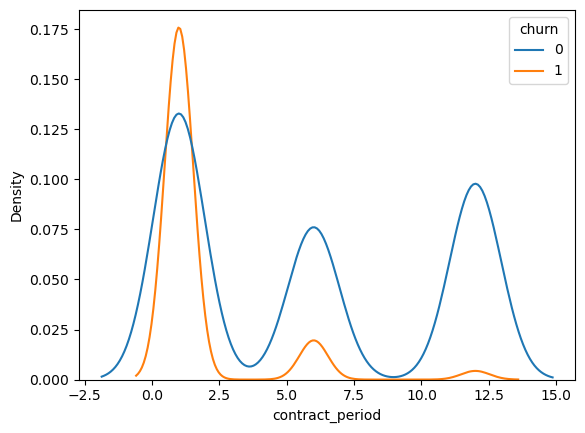

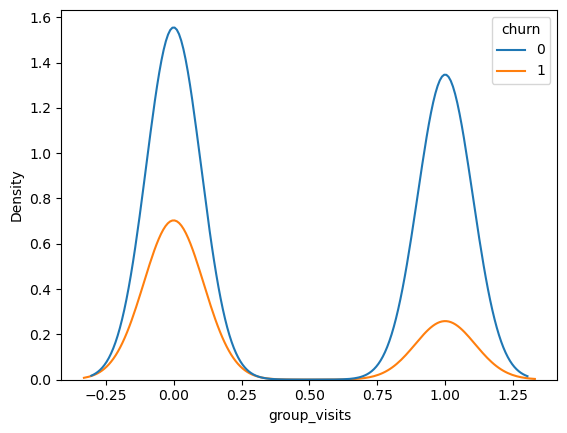

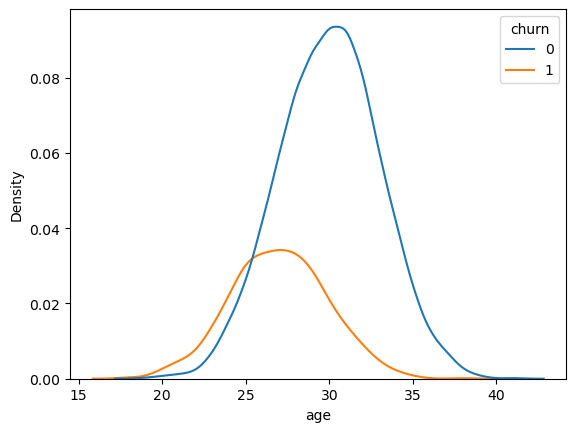

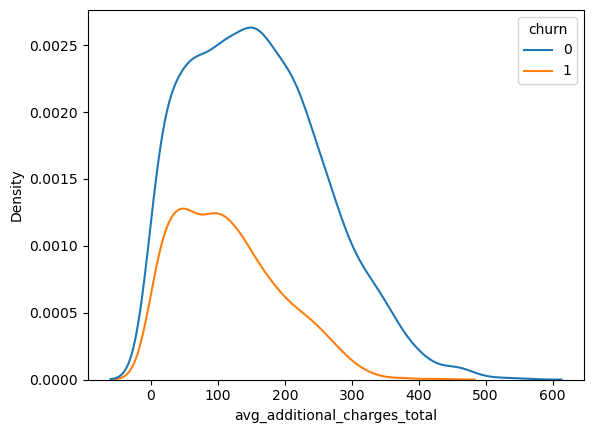

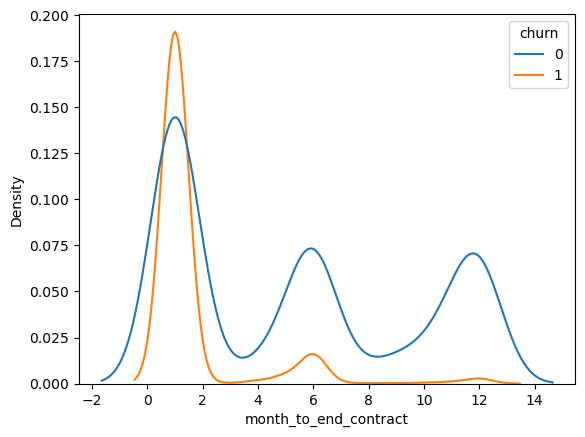

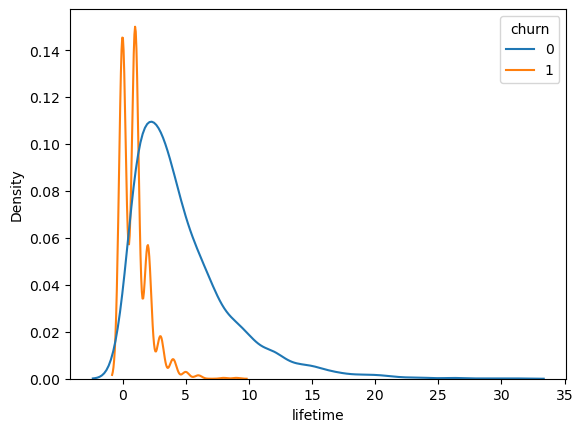

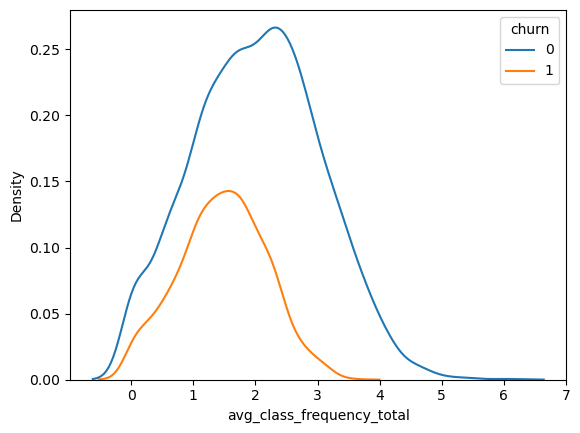

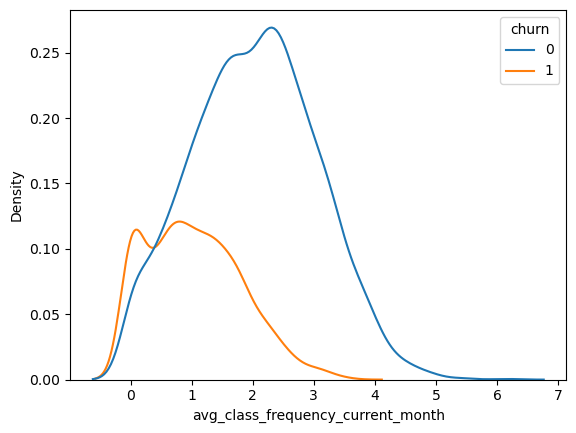

In [11]:
for col in df.drop('churn', axis = 1).columns:
    sns.kdeplot(x=df[col], hue=df['churn'])
    plt.show()

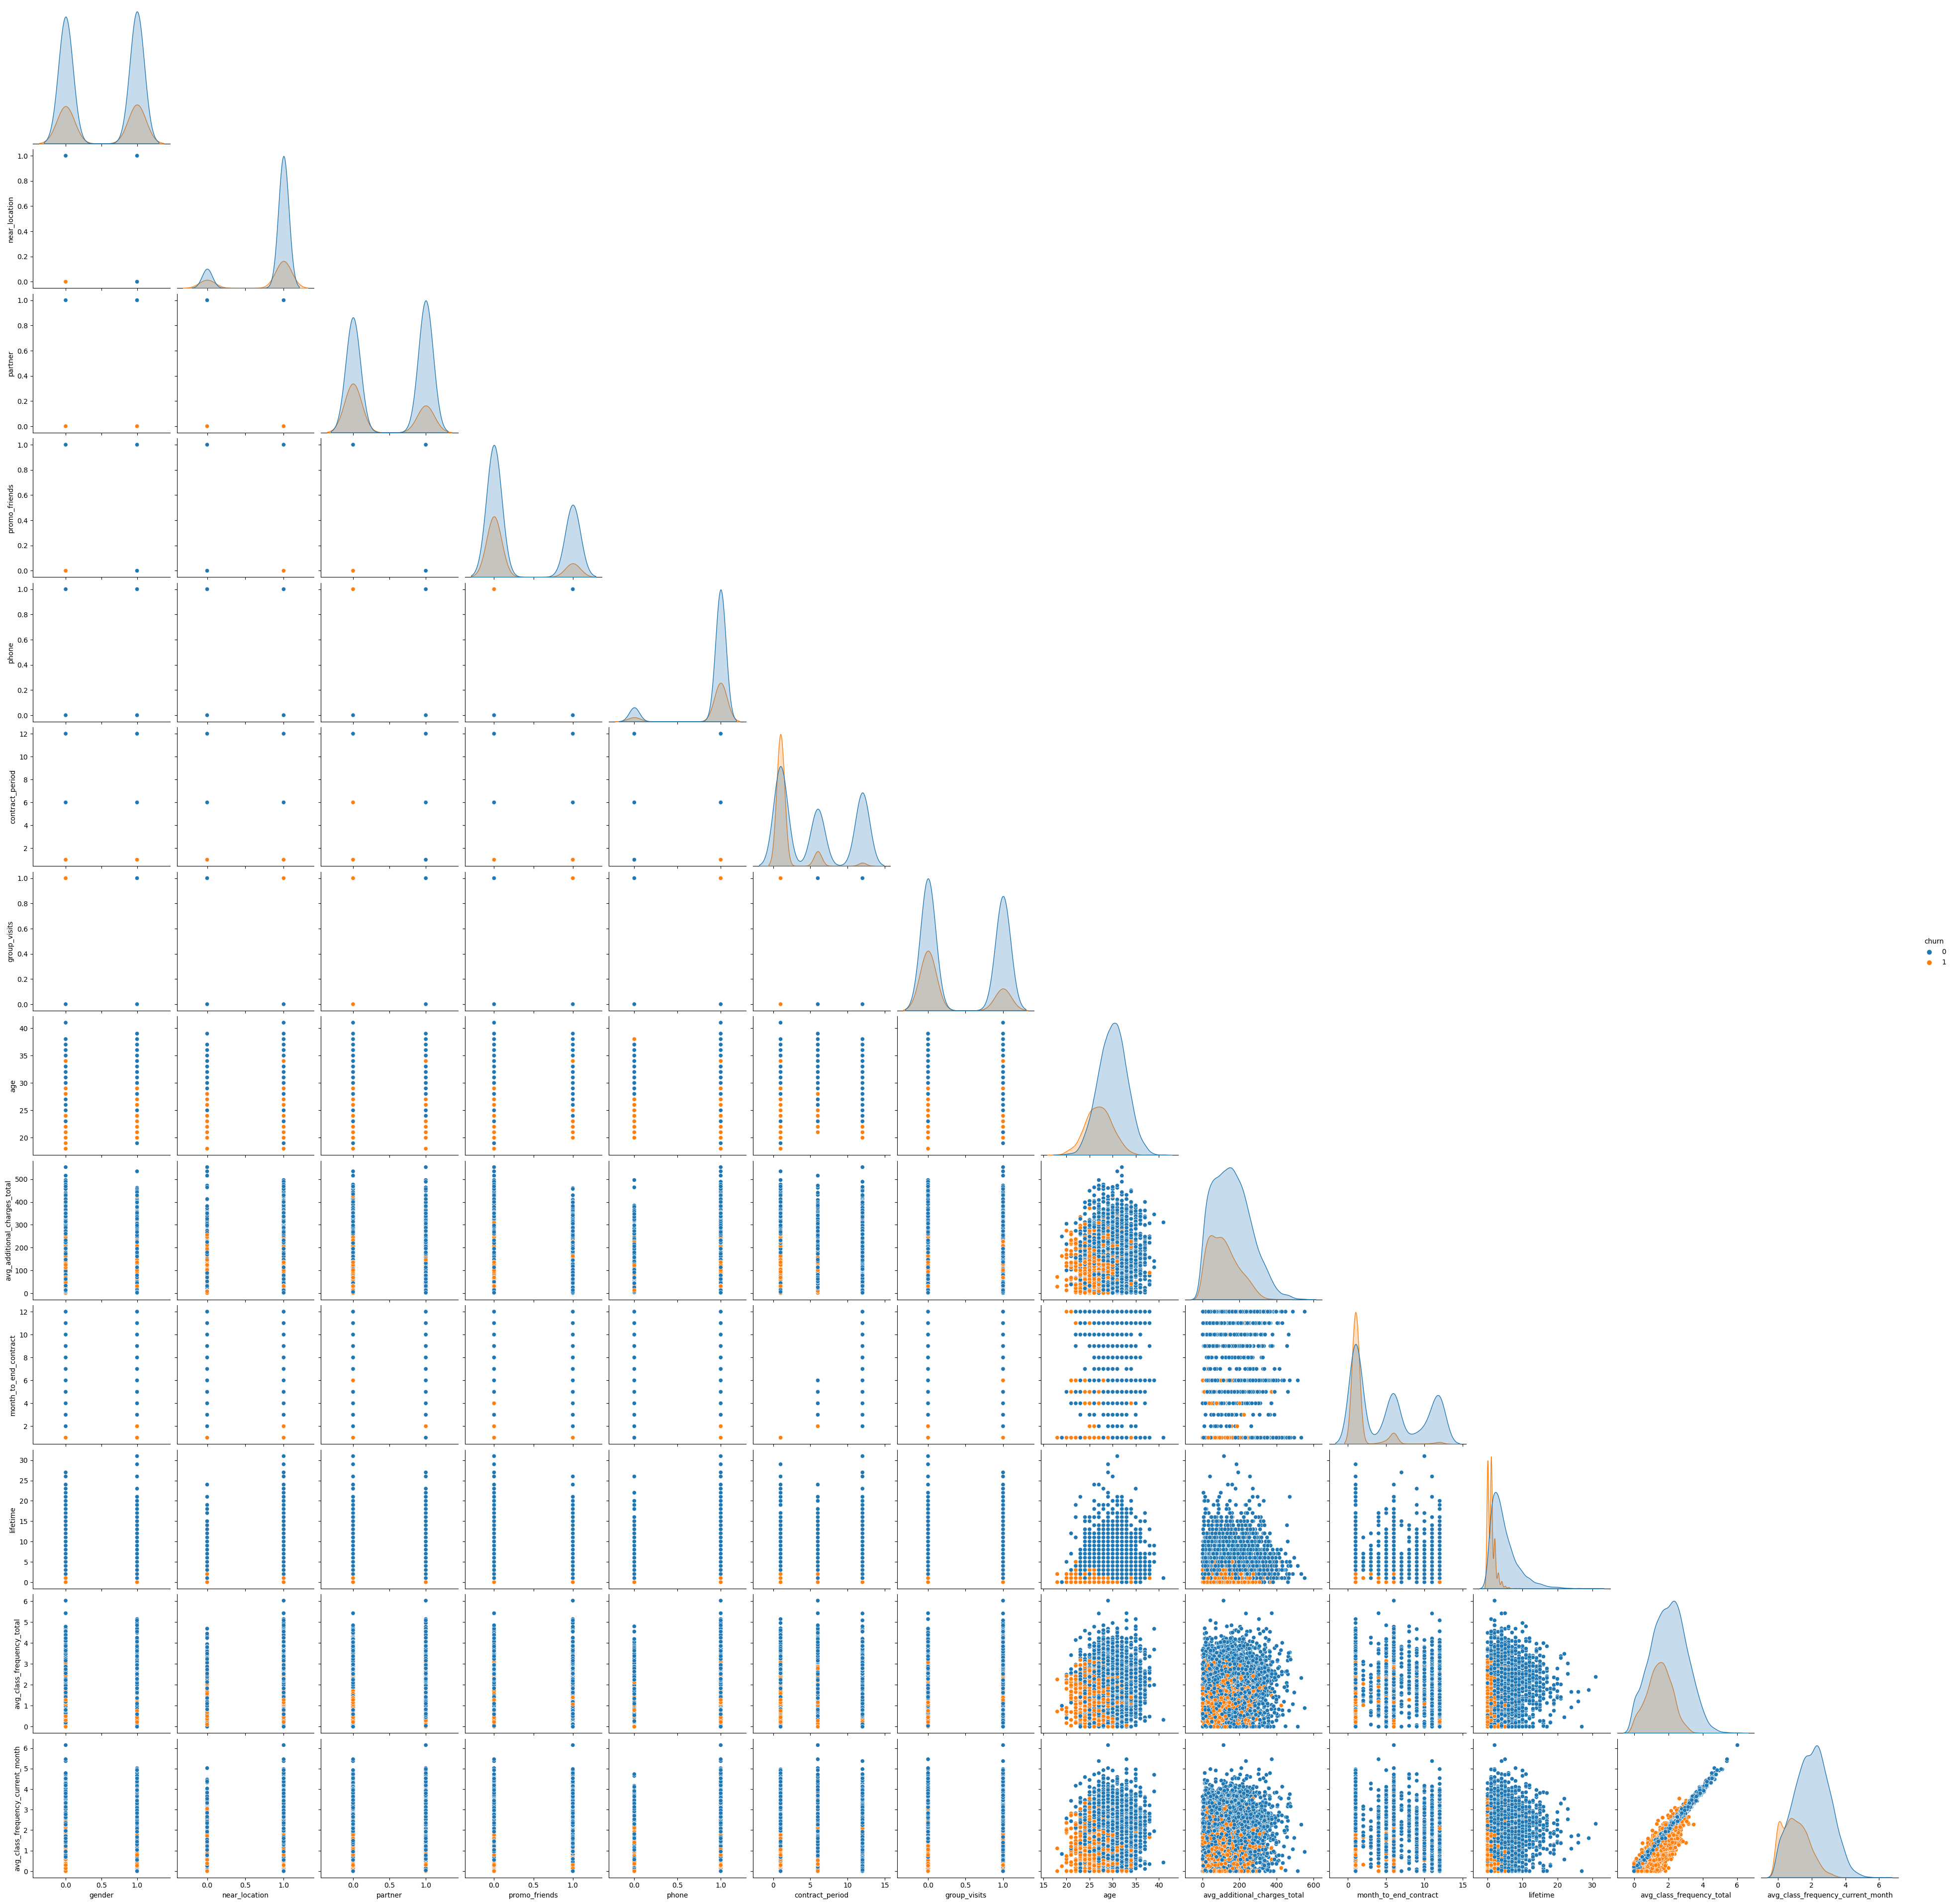

In [12]:
sns.pairplot(df,hue='churn',corner=True, height=3)

На основании диаграмм рассеяния можно определенно заметить, что отток бывает во всех категориальных группах (пол, локация, наличие телефона, партнерство, "приведи друга", групповые визиты), а также в группах по сроку действия абонемента. 

При этом, у пользователей от 35 до 40 лет отток встречается реже, чем у остальных. Аналогичная ситуация складывается для пользователей, потративших более 300 денег, а также у тех, кто пользуется услугами клуба от 10 до 31 месяца. Также и у посещающих зал более 3.5 раз в месяц и за весь период пользования. 

In [13]:
df_pivot_churn = df.groupby(by='churn').agg('mean')
df_pivot_churn

gender  near_location   partner  promo_friends     phone  \
churn                                                               
0      0.510037       0.873086  0.534195       0.353522  0.903709   
1      0.510839       0.768143  0.355325       0.183789  0.902922   

       contract_period  group_visits        age  avg_additional_charges_total  \
churn                                                                           
0             5.747193      0.464103  29.976523                    158.445715   
1             1.728558      0.268615  26.989632                    115.082899   

       month_to_end_contract  lifetime  avg_class_frequency_total  \
churn                                                               
0                   5.283089  4.711807                   2.024876   
1                   1.662582  0.990575                   1.474995   

       avg_class_frequency_current_month  
churn                                     
0                               2.027882  
1                               1.044546

По таблице средних значений по ушедшим и неушедшим посетителям можно в первом приближении определить характерные для каждой группы оттока показатели.

Среди ушедших **среднее значение срока абонемента 1.72 против 5.74 среди неушедших** - это говорит о том, что, скорее всего, в оттоке больше людей с абонементами на короткий срок.

**Средний возраст** для уходящих клиентов меньше - **26.98 против 29.97**: это может говорить о том, что к оттоку более склонны люди более молодого возраста. 

**Средние затраты на доп.услуги** среди уходящих ниже - **115.08 против 158.44**. 

**Среднее количество месяцев до окончания абонемента** среди уходящих также меньше - **1.66 против 5.28**: вкупе со средним значением срока абонемента это может быть связано с тем, что уходящие клиенты могут брать абонемент на короткий срок на пробу и уходить по причине того, что им что-то не нравится. 

Это предположение подкрепляет и **среднее значение "срока жизни"** уходящих - **0.99 месяца против 4.71** у остающихся. И еще более подкрепляющим оказывается фактор **среднего числа занятий в месяц и за весь период 1.044 и 1.47 для уходящих и 2.027 и 2.024 для остающихся** соответственно.

### Распределение признаков для уходящих и остающихся клиентов

Построим столбчатые гистограммы распределения признаков для клиентов в оттоке и остающихся. Это поможет дополнительно сделать предположения о том, какие черты наиболее характерны для каждой группы.

#### Диаграммы распределения признаков для клиентов в оттоке

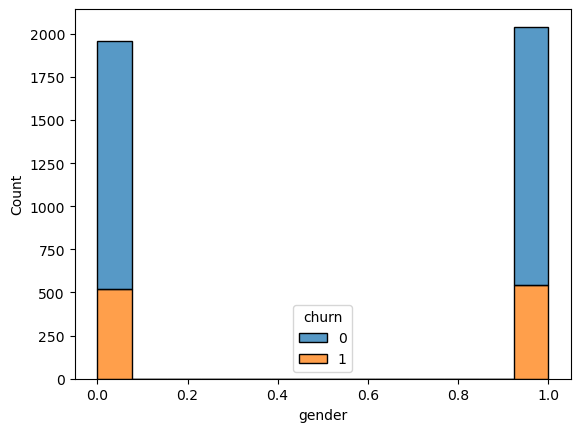

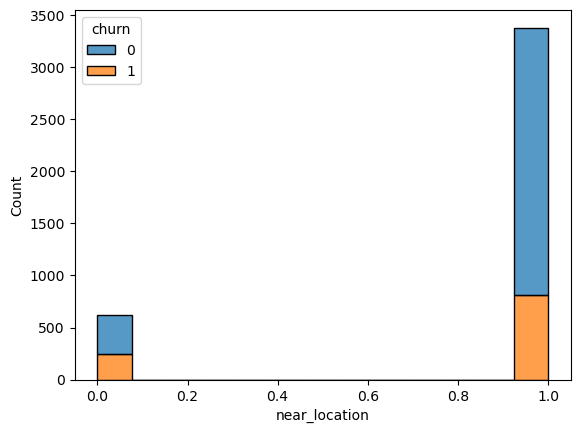

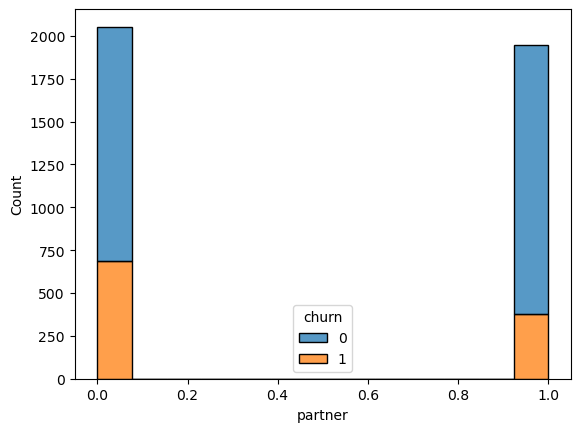

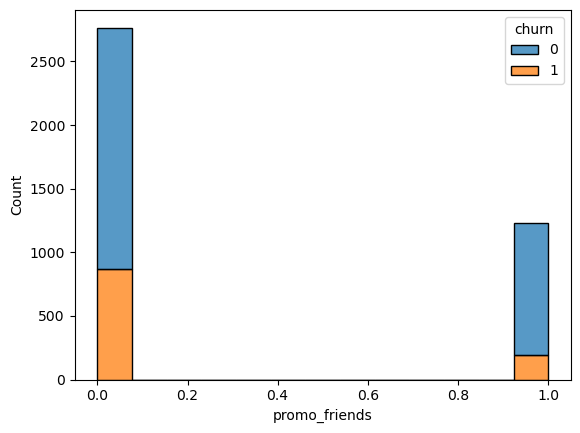

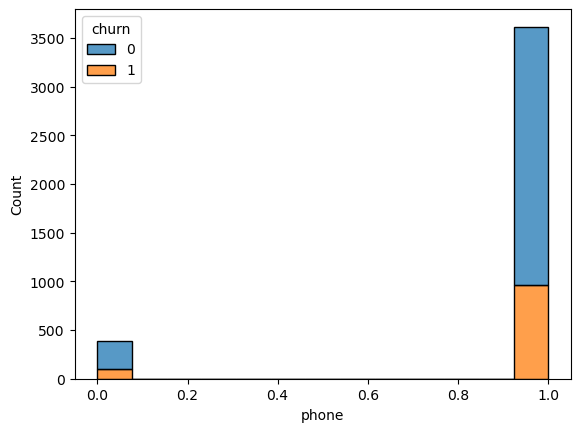

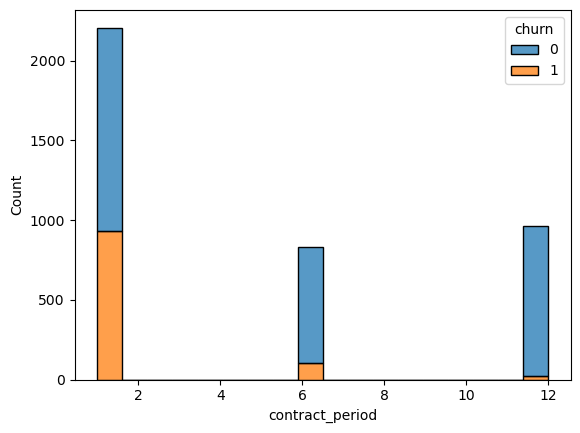

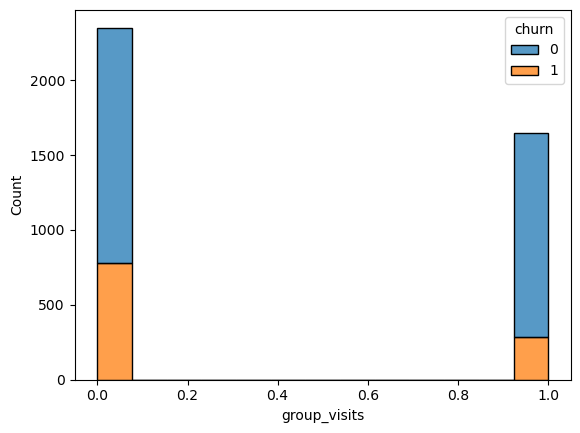

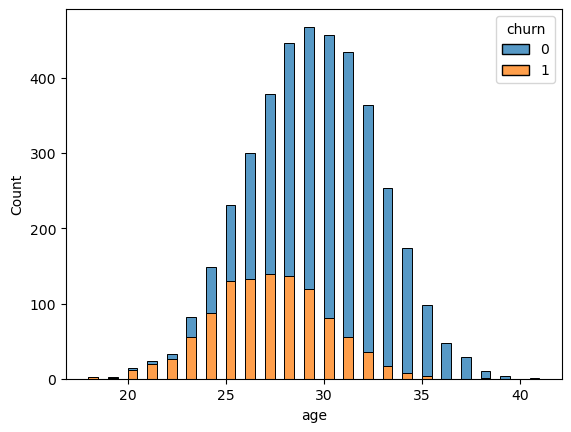

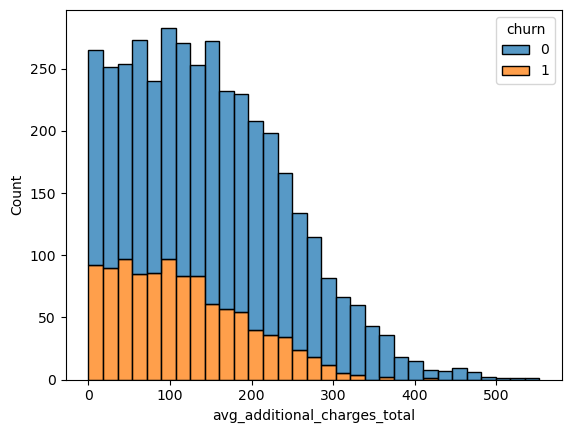

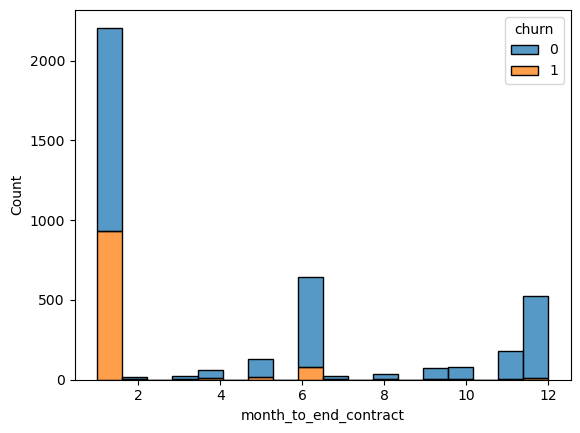

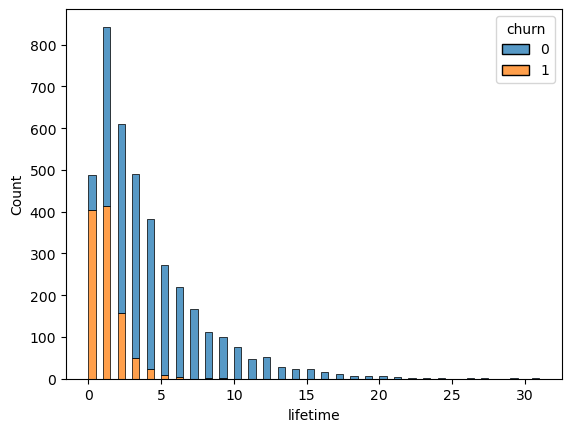

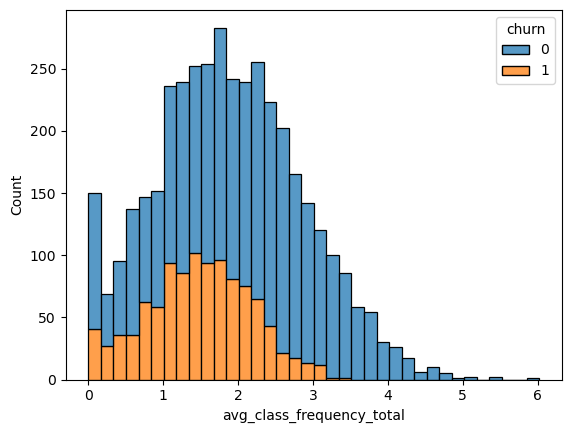

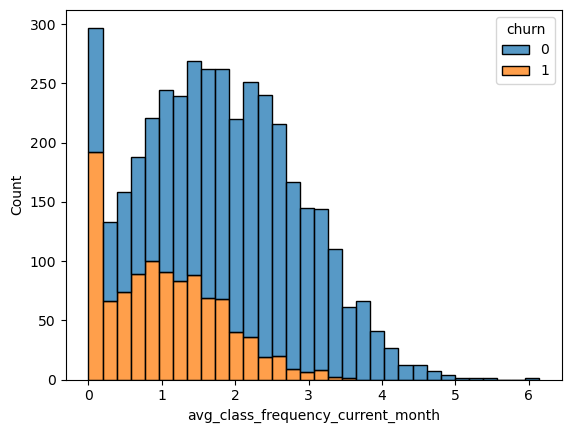

In [14]:
for col in df.drop('churn', axis = 1).columns:
    sns.histplot(x=df[col], hue=df['churn'],multiple='stack')
    plt.show()

По гистограммам распределения можно с уверенностью сказать, что среди уходящих пользователей, их **пол не является влияющим фактором**: оба пола представлены практически одинаково. 

Большинство пользователей пришли без партнерской программы и без рекомендации друзей.

Наиболее часто среди уходящих встречается **месячный абонемент**.

Больше всего уходит пользователей **в возрасте от 23 до 28 лет**.

В среднем они **тратят до 110-120 рублей на дополнительные услуги**.

**"Срок жизни"** клиента в оттоке чаще всего составляет **до 2 месяцев**.

Чаще всего такие пользователи **посещают клуб около 1 раза в месяц за все время и за текущий месяц**.

#### Диаграммы распределения признаков для остающихся клиентов

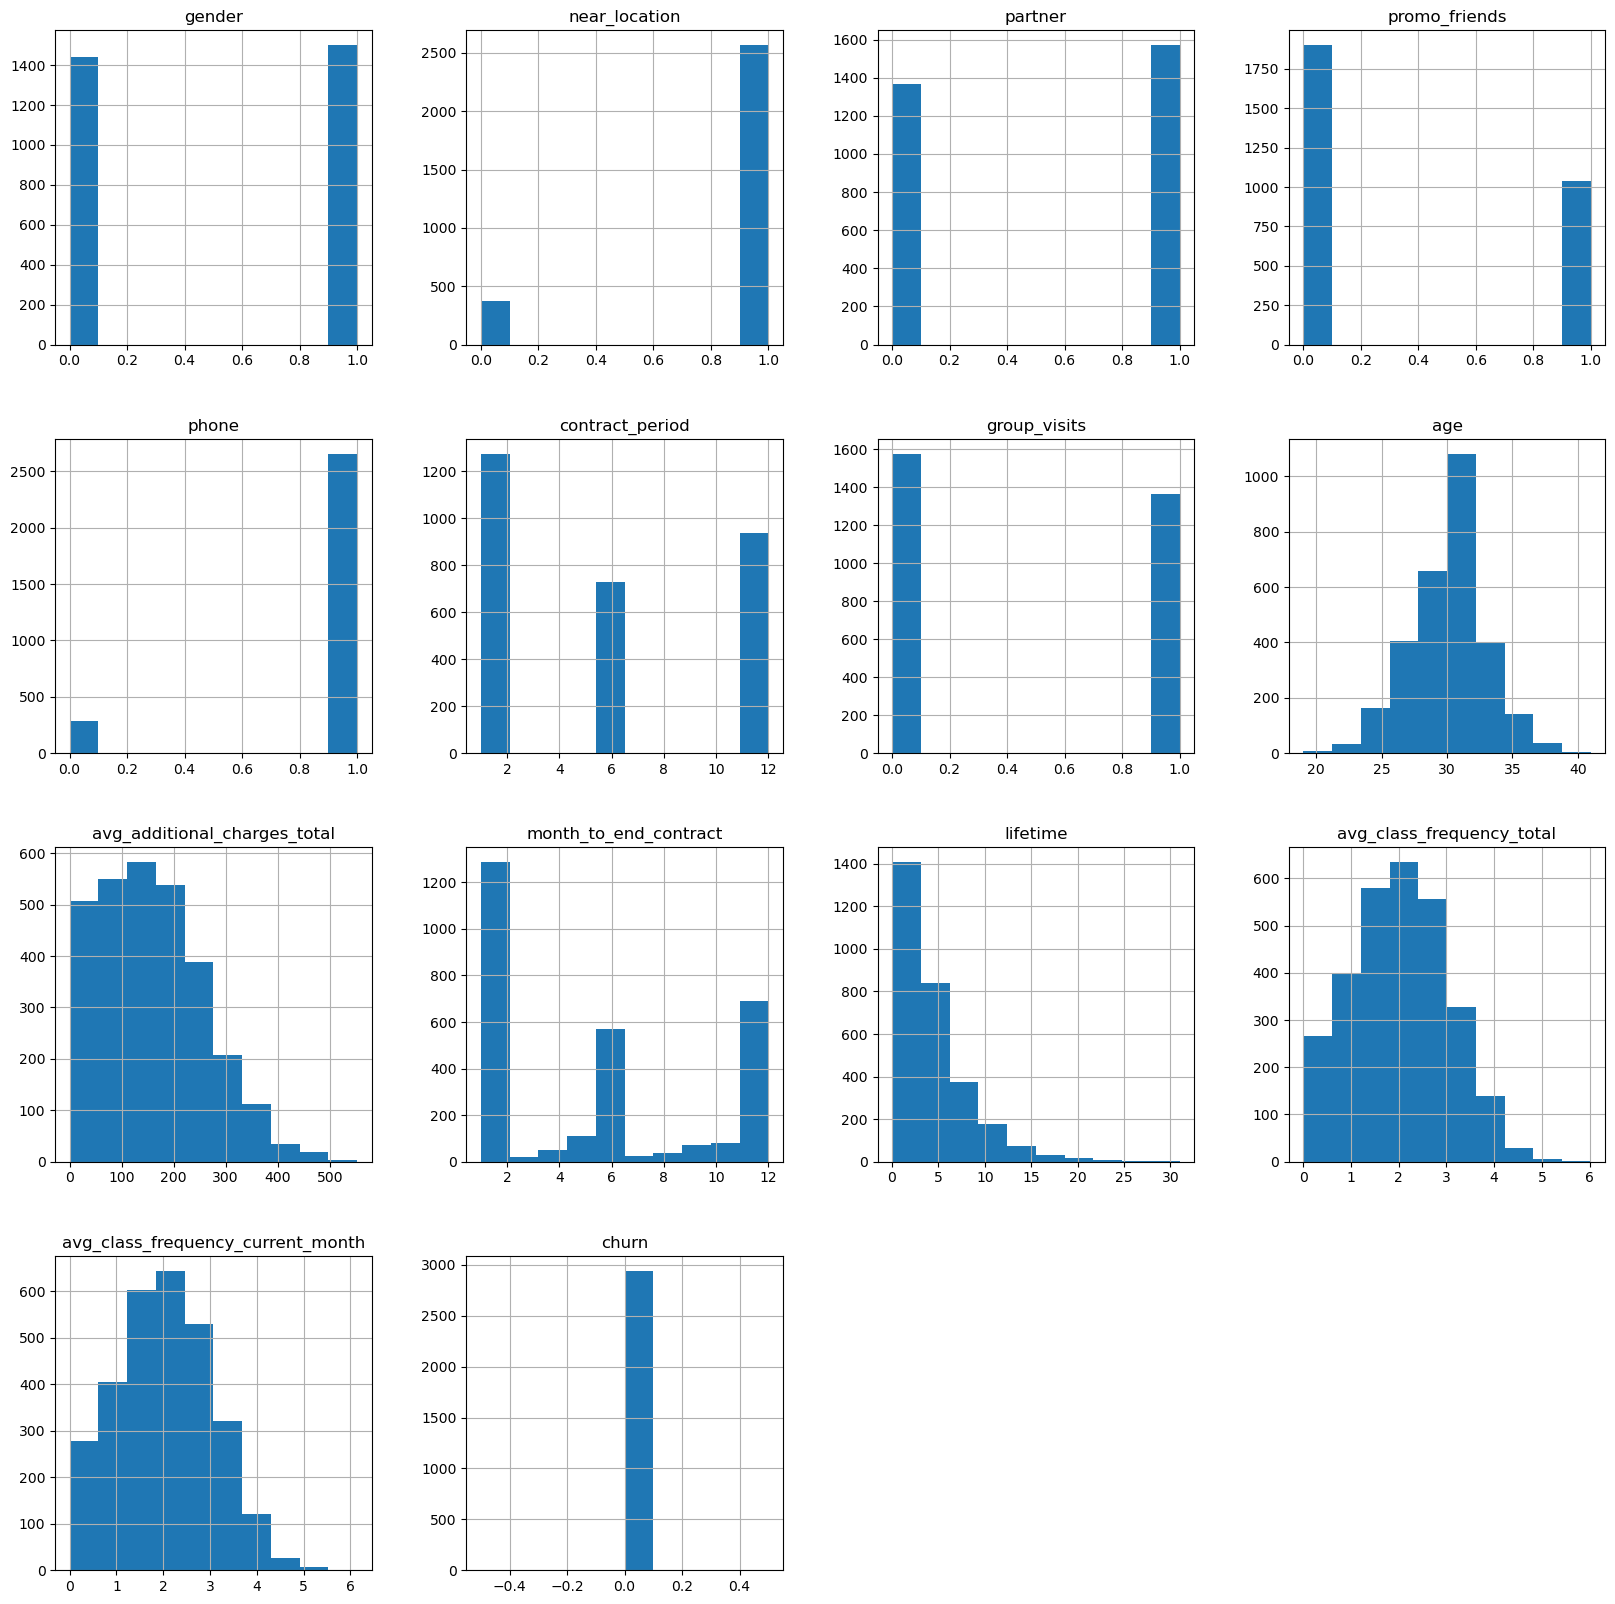

In [15]:
df.query('churn == 0').hist(figsize=(20, 20))
plt.show()

В сравнении с уходящими, остающиеся клиенты имеют более интересные показатели.

**Примерно одинаковое их количество приходит по партнерским программам и самостоятельно**. 

**По рекомендациям** приходит **вполовину меньше людей, чем самостоятельно** (однако это не означает что они не могут приходить одновременно и по рекомендации и по партнерской программе, либо приходить самостоятельно без иных влияющих на решение факторов).

Среди остающихся клиентов **часто встречаются не только месячные, но и полугодовые и годовые абонементы**.

Остающиеся клиенты чаще всего **в возрасте от 28 лет и старше**.

**Средние траты на доп.услуги** чаще всего составляют **до 220 денег**.

Чаще всего остающиеся клиенты **посещают клуб в среднем в месяц от 1 до 3 раз, и за все время - от 1.5 до 3 раз**.

### Выводы

По итогам проведенного предварительного анализа можно определить примерный портрет пользователя, уходящегов отток. Однако это не является определяющим. В отток могут попадать любые клиенты с практически любым набором показателей.

При этом, наиболее распространенные их черты уже были определены, и в дальнейшем полученную информацию дополним результатами работы модели машинного обучения, применяемой для прогнозирования оттока клиентов по имеющимся данным.

## Модель прогнозирования оттока клиентов

### Подготовка выборок для обучения модели

Для прогнозирования возможного оттока клиента используем две модели:

* Логистическая регрессия
* Случайный лес

И по итогам работы и оценки показателей каждой выберем наиболее подходящую для прогнозирования оттока в будущем периоде.

#### Функция вывода основных метрик моделей

Также сразу напишем функцию, которая будет выводить метрики для каждой из моделей, чтобы сделать код более простым и лаконичным.

In [16]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

Теперь разделим данные на обучающую и тестовую выборки, а также выделим целевую переменную (churn) и все остальные признаки, влияющие на отток.

In [17]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis=1)
y = df['churn']
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Стандартизируем тренировочную и тестовую выборки для нормализации всех имеющихся признаков.

In [18]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Зададим алгоритмы для обеих упомянутых выше моделей и выведем итоговые метрики для их оценки.

### Показатели модели линейной регрессии

In [19]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
	F1: 0.84
	ROC_AUC: 0.97


Также дополнительно оценим средний модуль ошибки, среднюю квадратичную ошибку и коэффициент детерминации.

In [20]:
print('Mean: {:.2f}'.format(y_test.mean()))
print('MAE: {:.2f}'.format(mean_absolute_error(y_test, lr_predictions)))
print('MSE: {:.2f}'.format(mean_squared_error(y_test, lr_predictions)))
print('R2: {:.2f}'.format(r2_score(y_test, lr_predictions)))

Mean: 0.25
MAE: 0.08
MSE: 0.08
R2: 0.58


### Показатели модели случайного леса

In [21]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(random_state=0) # Ваш код здесь
# обучим модель случайного леса
rf_model.fit(X_train_st,y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st) # Ваш код здесь
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1] # Ваш код здесь
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities, 
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81
	F1: 0.83
	ROC_AUC: 0.97


Аналогично модели линейной регресии оценим метрики ошибок модели.

In [22]:
print('Mean: {:.2f}'.format(y_test.mean()))
print('MAE: {:.2f}'.format(mean_absolute_error(y_test, rf_predictions)))
print('MSE: {:.2f}'.format(mean_squared_error(y_test, rf_predictions)))
print('R2: {:.2f}'.format(r2_score(y_test, rf_predictions)))

Mean: 0.25
MAE: 0.09
MSE: 0.09
R2: 0.54


### Сравнение показателей моделей и выводы

**Доля правильных ответов** у обеих моделей **одинакова** и составляет **0.92**.

**Точность** модели **логистической регрессии** незначительно выше, чем у модели **случайного леса**: **0.85** против **0.84**.

**Полнота** модели **логистической регрессии** выше, чем у модели **случайного леса**: **0.83** против **0.81**.

**F1-метрика** у **логистической регрессии** также немногим выше, чем у **случайного леса**: **0.84** против **0.83**.

Показатель **ROC-AUC** для обеих моделей **одинаков** и составляет **0.97**.

Сравнивая обе модели можно обратить внимание, что их метрики немногим отличаются друг от друга в пользу модели линейной регрессии. Однако на основе полученных метрик достаточно сложно выбрать одну из моделей для прогнозирования будущего оттока. 

Более того, метрики ошибок показывают, что модели обучились и смогли сделать достаточно правдоподобные прогнозы по оттоку, однако коэффициент детерминации немногим более 0.50 для линейной регрессии (0.58) и для случайного леса (0.54). Это не говорит о том, что модели плохи - напротив, они могут достаточно верно прогнозировать отток. Тем не менее, есть резон предположить, что можно иным образом попробовать более точно предсказать отток с б**о**льшим коэффициентом детерминации.

Возможно, необходимо применить иные методики построения моделей, и сравнить их итоговые метрики для выбора более точной. Однако, при прочих равных условиях, при использовании любой из уже обученных и протестированных моделей, мы можем получить вполне правдоподобный прогноз оттока клиентов в будущем месяце.

## Кластеризация клиентов

В рамках исследовательского анализа данных ранее уже поднимался вопрос о разделении клиентов фитнес-клуба на определенные группы, которым характерны те или иные особенности.

Поэтому, с помощью модели K-Means проведем кластеризацию клиентов и разделим их на группы, и в дальнейшем рассмотрим их.

### Кластеризация и построение дендрограммы

Перед проведением кластеризации проведем стандартизацию выборки признаков.

In [23]:
X_sc = scaler.fit_transform(X)
linked = linkage(X_sc, method = 'ward') 

Теперь на основе переменной linked можно построить дендрограмму.

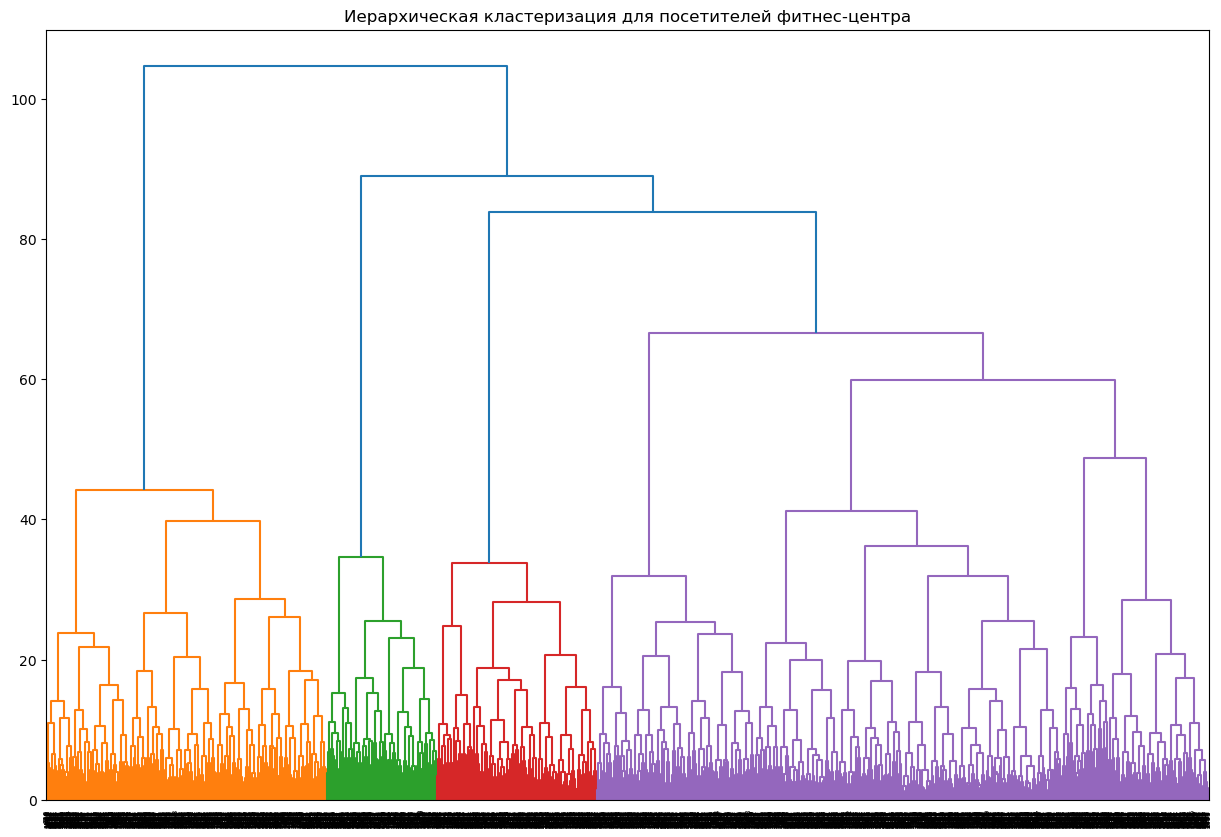

In [24]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация для посетителей фитнес-центра')
plt.show() 

Модель предлагает рассмотреть 4 крупных кластера. Из исследовательского анализа данных следует, что, скорее всего, эти кластеры будут учитывать показатели возраста, пола, срока абонемента, частоты посещений, а также фактора привлечения посетителя по акции/партнерской программе. 

Однако, один из кластеров весьма большой, и вполне сопоставим с остальными тремя. Поэтому, для большей глубины анализа можно разделить его на 2 части, либо более. Поэтому для исследования по K-Means будем использовать 5 кластеров.

### Кластеризация по модели K-Means и анализ кластеров

Как упоминалось ранее, для модели будем использовать 5 предполагаемых кластеров. Построим модель и проведем исследование полученных результатов.

In [25]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров 

Дополним датафрейм столбцом с кластерами и отобразим статистику по средним значениям.

In [26]:
df['cluster'] = labels
df.groupby('cluster').agg('mean')

gender  near_location   partner  promo_friends     phone  \
cluster                                                               
0        0.502970       0.959406  0.783168       0.574257  1.000000   
1        0.522078       0.862338  0.470130       0.306494  0.000000   
2        0.495050       0.000000  0.463366       0.079208  1.000000   
3        0.485737       1.000000  0.350238       0.240095  1.000000   
4        0.559666       0.976134  0.356802       0.230310  0.998807   

         contract_period  group_visits        age  \
cluster                                             
0              10.889109      0.542574  29.982178   
1               4.787013      0.425974  29.301299   
2               2.352475      0.215842  28.477228   
3               1.948494      0.341521  28.167987   
4               2.669451      0.473747  30.125298   

         avg_additional_charges_total  month_to_end_contract  lifetime  \
cluster                                                                  
0                          160.761016               9.954455  4.736634   
1                          143.957664               4.475325  3.924675   
2                          135.457501               2.198020  2.809901   
3                          131.622204               1.856577  2.440571   
4                          161.657905               2.459427  4.898568   

         avg_class_frequency_total  avg_class_frequency_current_month  \
cluster                                                                 
0                         1.982055                           1.974789   
1                         1.847220                           1.716369   
2                         1.660461                           1.477324   
3                         1.247634                           1.012983   
4                         2.852002                           2.850161   

            churn  
cluster            
0        0.027723  
1        0.267532  
2        0.443564  
3        0.514263  
4        0.068019

По полученной таблице средних видно, чтов каждом кластере примерно одинаковое количество мужчин и женщин; есть отдельные кластеры для посетителей, которые живут рядом и нет; также есть кластеры посетителей без указанного номера телефона; средний возраст посетителей примерно одинаков везде.

Можно обратить внимание, что весьма явно прослеживается разделение по сроку действия абонемента, количеству месяцев до его окончания, а также по сроку жизни клиента.

Если обратить внимание на распределение по средней частоте посещений также можно предположить, что этот показатель также имеет некоторое влияние на отнесение посетителя к тому или иному кластеру.

### Распределение показателей по кластерам

Для визуализации распределения показателей по кластерам построим графики распределения попарно, учитывая кластеры в цветовом окрасе точек.

Предварительно зададим функцию отрисовки требуемых графиков.

In [27]:
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 10))
    sns.kdeplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

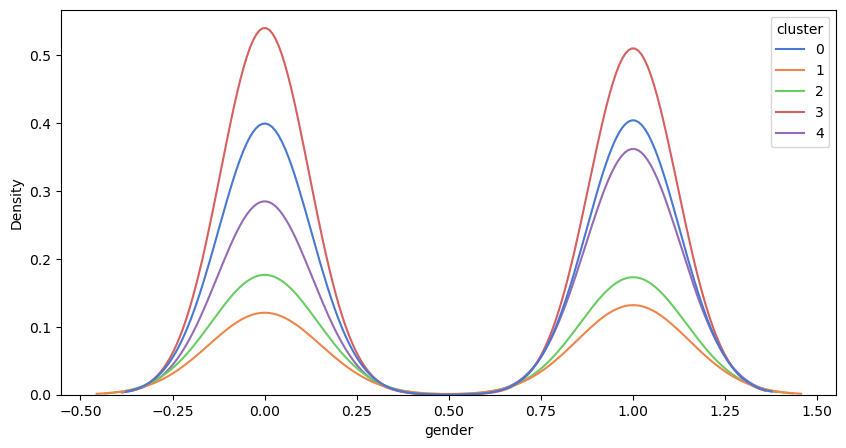

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


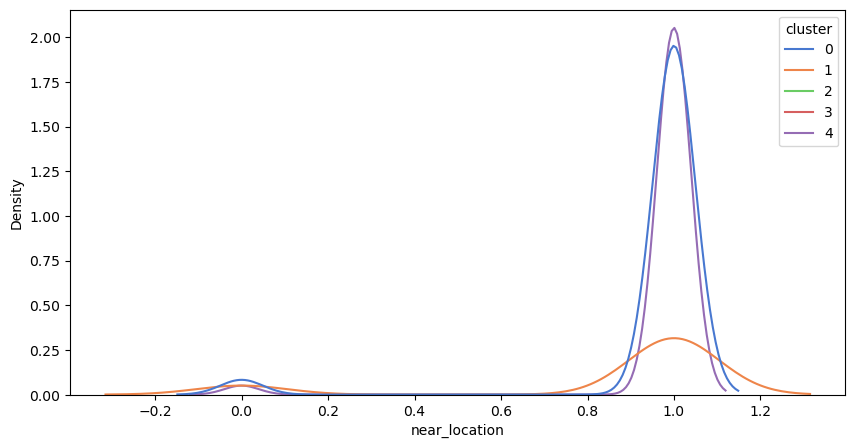

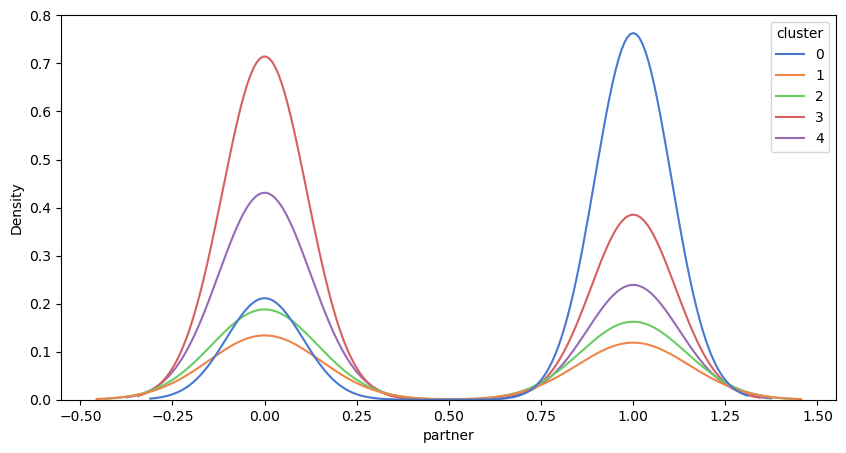

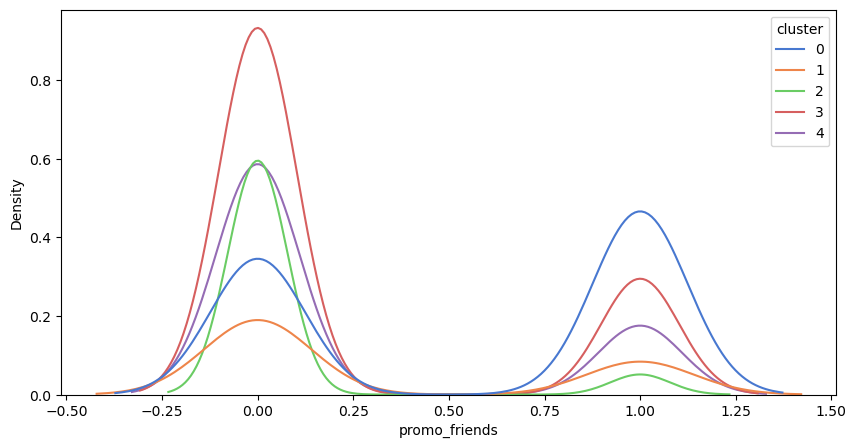

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


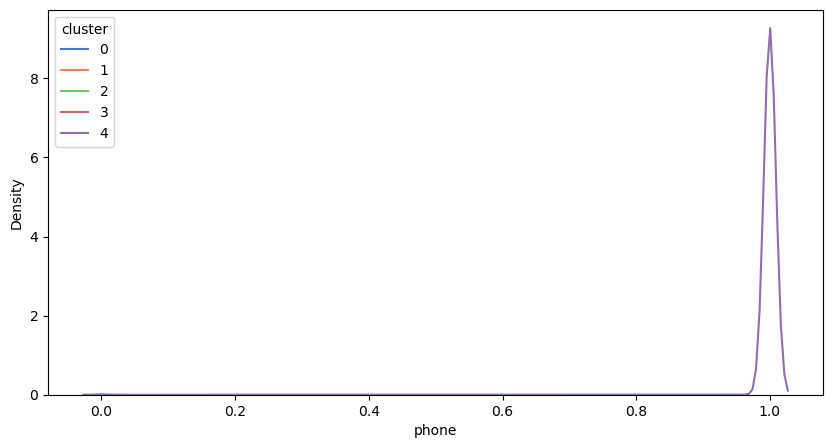

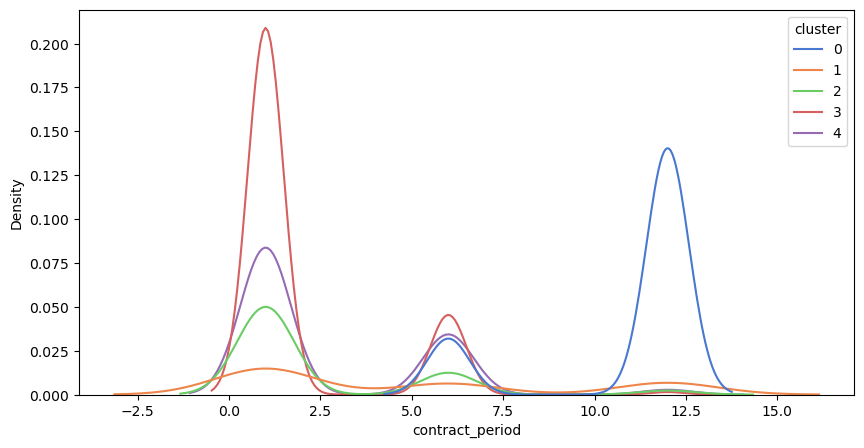

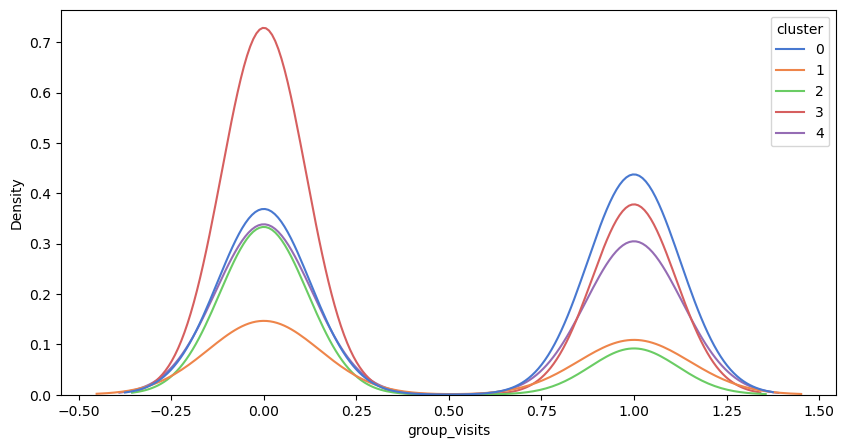

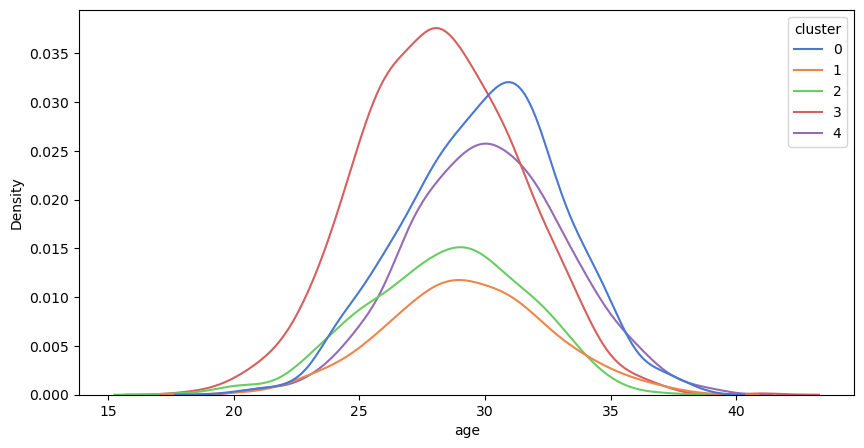

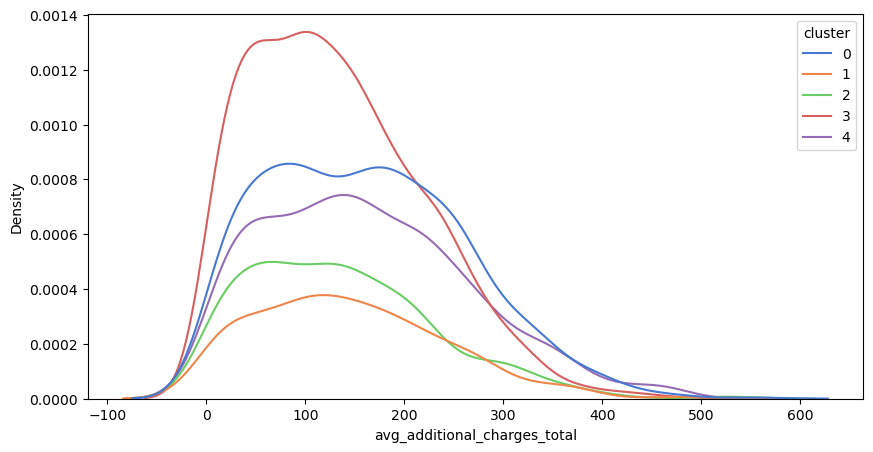

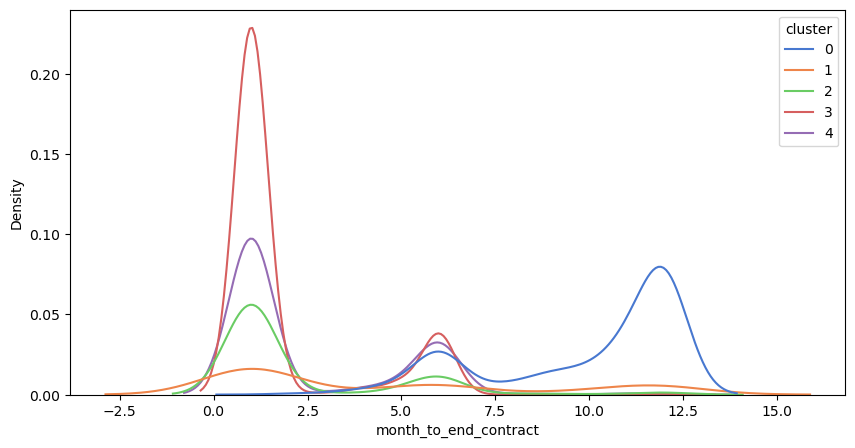

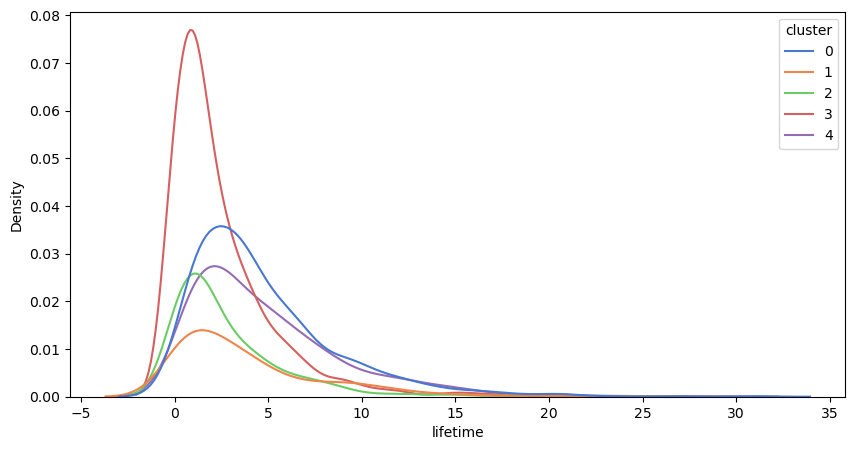

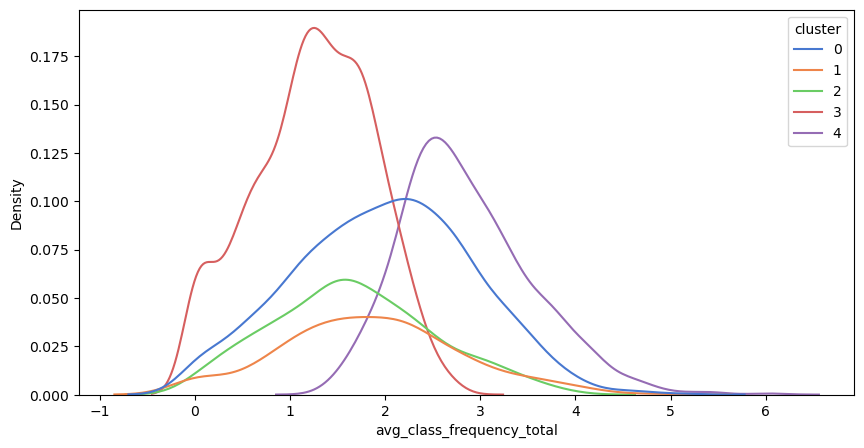

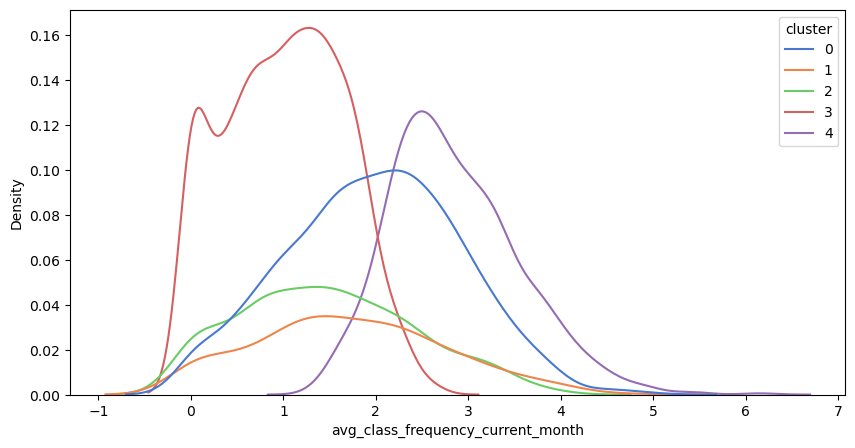

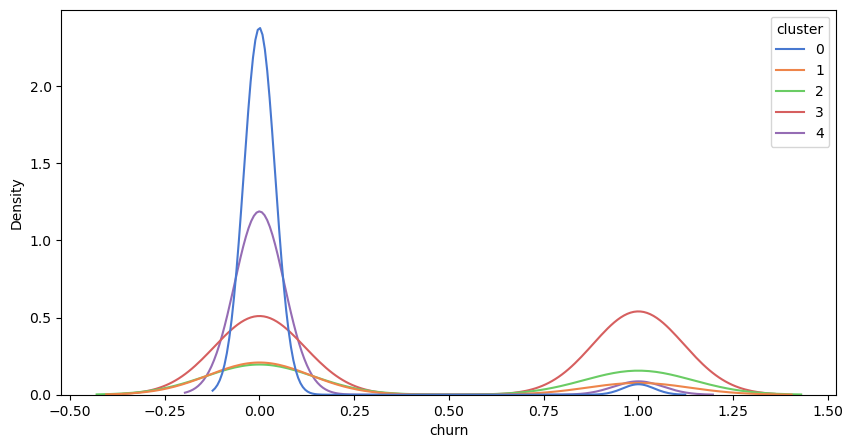

In [28]:
for col in df.drop('cluster', axis = 1).columns:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(x=df[col], hue=df['cluster'], palette='muted')
    plt.show()

В целом, как описывалось ранее по таблице средних значений для кластеров, наблюдается включение в некоторые кластеры отдельных групп, где превалируют или являются единственным отнесенным значением определенные бинарные значения соответствующих признаков. Также, достаточно явно видно, как распределены по кластерам комбинации некоторых значений (например, частота посещения и дополнительные траты на сопутствующие услуги).

Тем не менее, для оценки проведенной кластеризации разумно посчитать соответствующую метрику (Silhouette score).

In [30]:
silhouette_score(X_sc, labels)

0.14140953623023353

Показатель метрики близок к нулю, но, учитывая, что он принимает значения от -1 до 1 - кластеризация в целом неплохая.

Тем не менее, возможно, стоит изменить подход к выведению кластеров.

Дополнительно для информации изучим распределение значений по каждому из кластеров, чтобы понять, какие примерно группы пользователей попали в них.

### Характеристики кластеров

**Кластер 1**

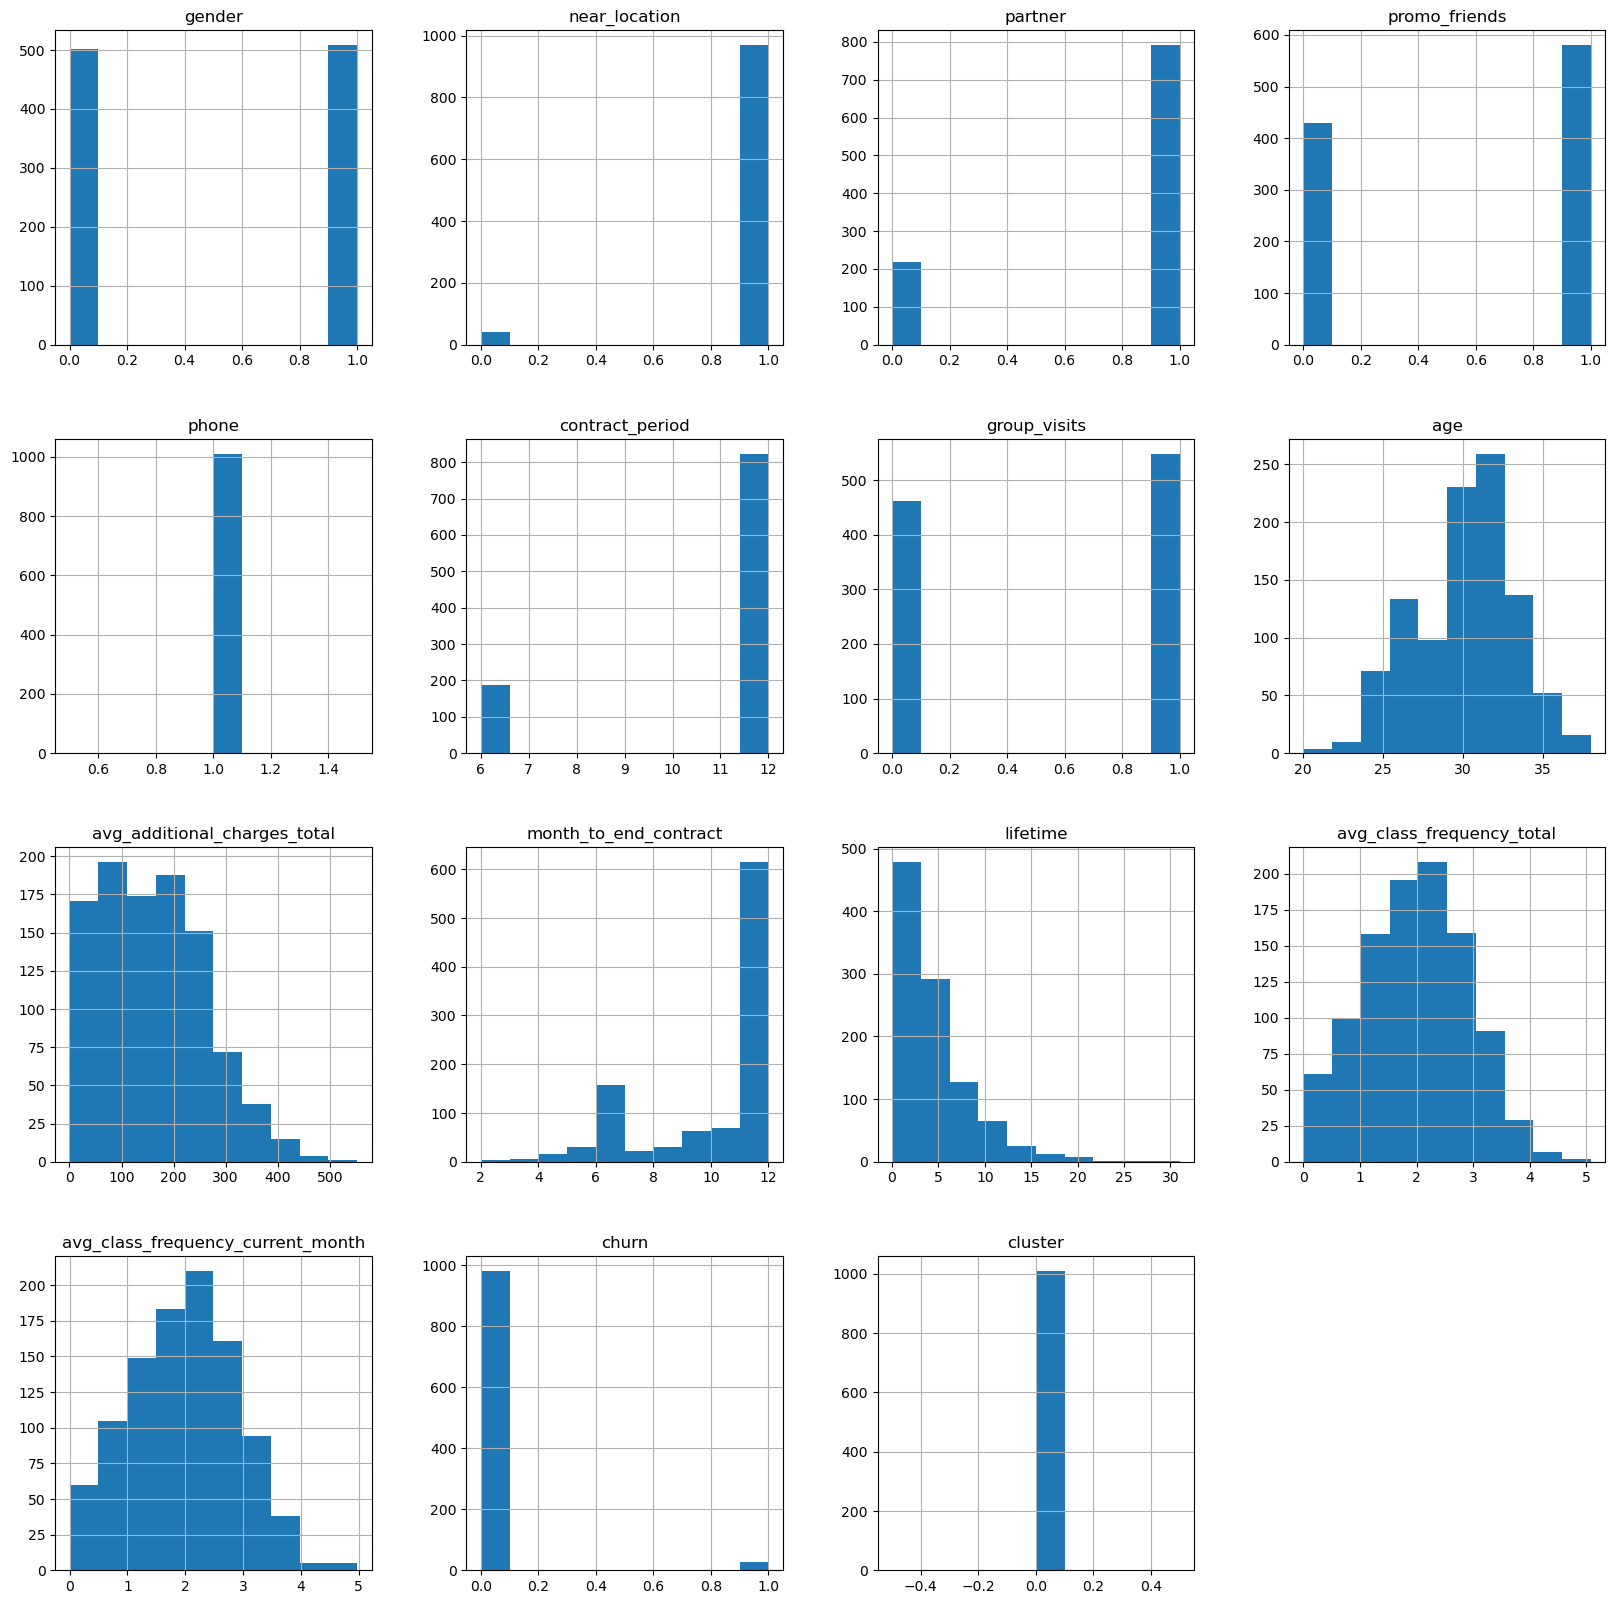

In [31]:
df.query('cluster == 0').hist(figsize=(20, 20))
plt.show()

Основные характеристики кластера:
* Примерно поровну мужчин и женщин
* Большинство клиентов работают или живут рядом с клубом
* Около 75% клиентов привлечены по партнерской программе
* Около 60% клиентов привлечены по акции "приведи друга" (не взаимоисключающе с предыдущим пунктом)
* У всех клиентов есть информация о номере телефона
* Абонементы клиентов со сроками от 6 до 12 месяцев
* Около 55% ходят на групповые занятия
* Возраст от 20 до 38 лет (самый распространенный - промежуток от 30 до 35)
* Траты на дополнительные услуги - от 100 до 250 денег
* Остается от 6 до 12 месяцев до окончания срока абонемента
* Привлечены в клуб около полугода назад
* В целом посещают клуб от 1 до 2.5 раз в месяц
* Практически отсутствует отток

Можно считать этот кластер "увлеченными спортсменами", которые настроены на долгое использование клуба.

**Кластер 2**

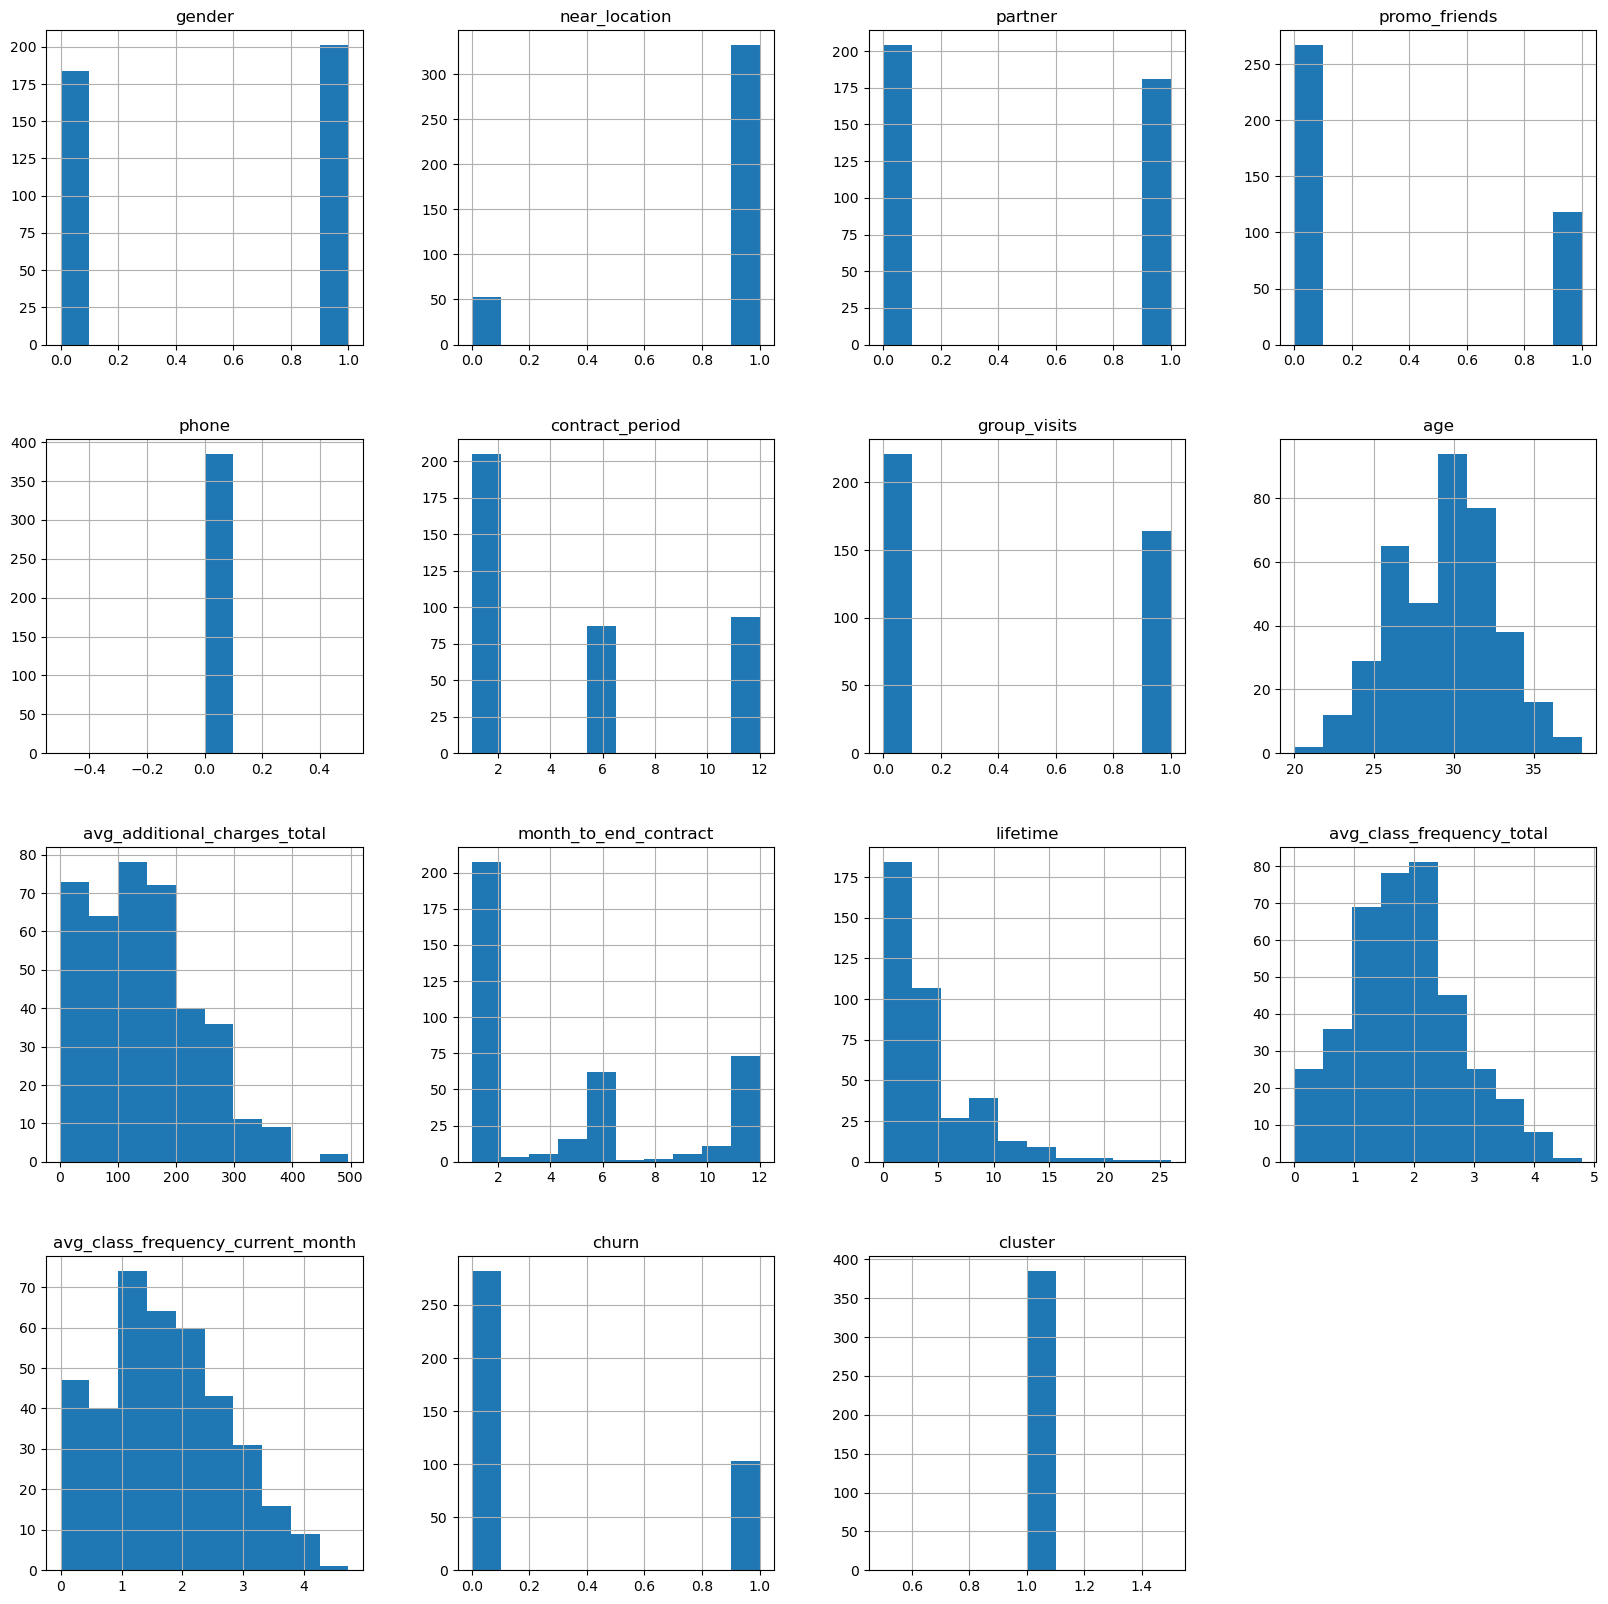

In [32]:
df.query('cluster == 1').hist(figsize=(20, 20))
plt.show()

Основные характеристики кластера:
* Примерно поровну мужчин и женщин
* Большинство клиентов работают или живут рядом с клубом. Есть некоторое число клиентов из других районов.
* Около 40% клиентов привлечены по партнерской программе
* Около 30% клиентов привлечены по акции "приведи друга" (не взаимоисключающе с предыдущим пунктом)
* У всех клиентов нет информации о номере телефона
* Абонементы клиентов со сроками от 1 до 12 месяцев (до 50% месячных, остальных примерно по 25%)
* Около 55% не ходят на групповые занятия
* Возраст от 20 до 38 лет (самый распространенный - промежуток от 25 до 30)
* Траты на дополнительные услуги - от 0 до 200 денег
* Остается от 1 до 12 месяцев до окончания срока абонемента (у большинства - 1 месяц)
* Привлечены в клуб менее полугода назад
* В целом посещают клуб от 1 до 2 раз в месяц
* Отток около 25%

Кластер можно охарактеризовать как "молодые люди, открывающие мир спорта". Они уже берут длительные абонементы и ходят в зал достаточно часто в среднем, при этом тратят деньги на дополнительные услуги. Они младше клиентов 1го кластера, но имеют похожие черты.

**Кластер 3**

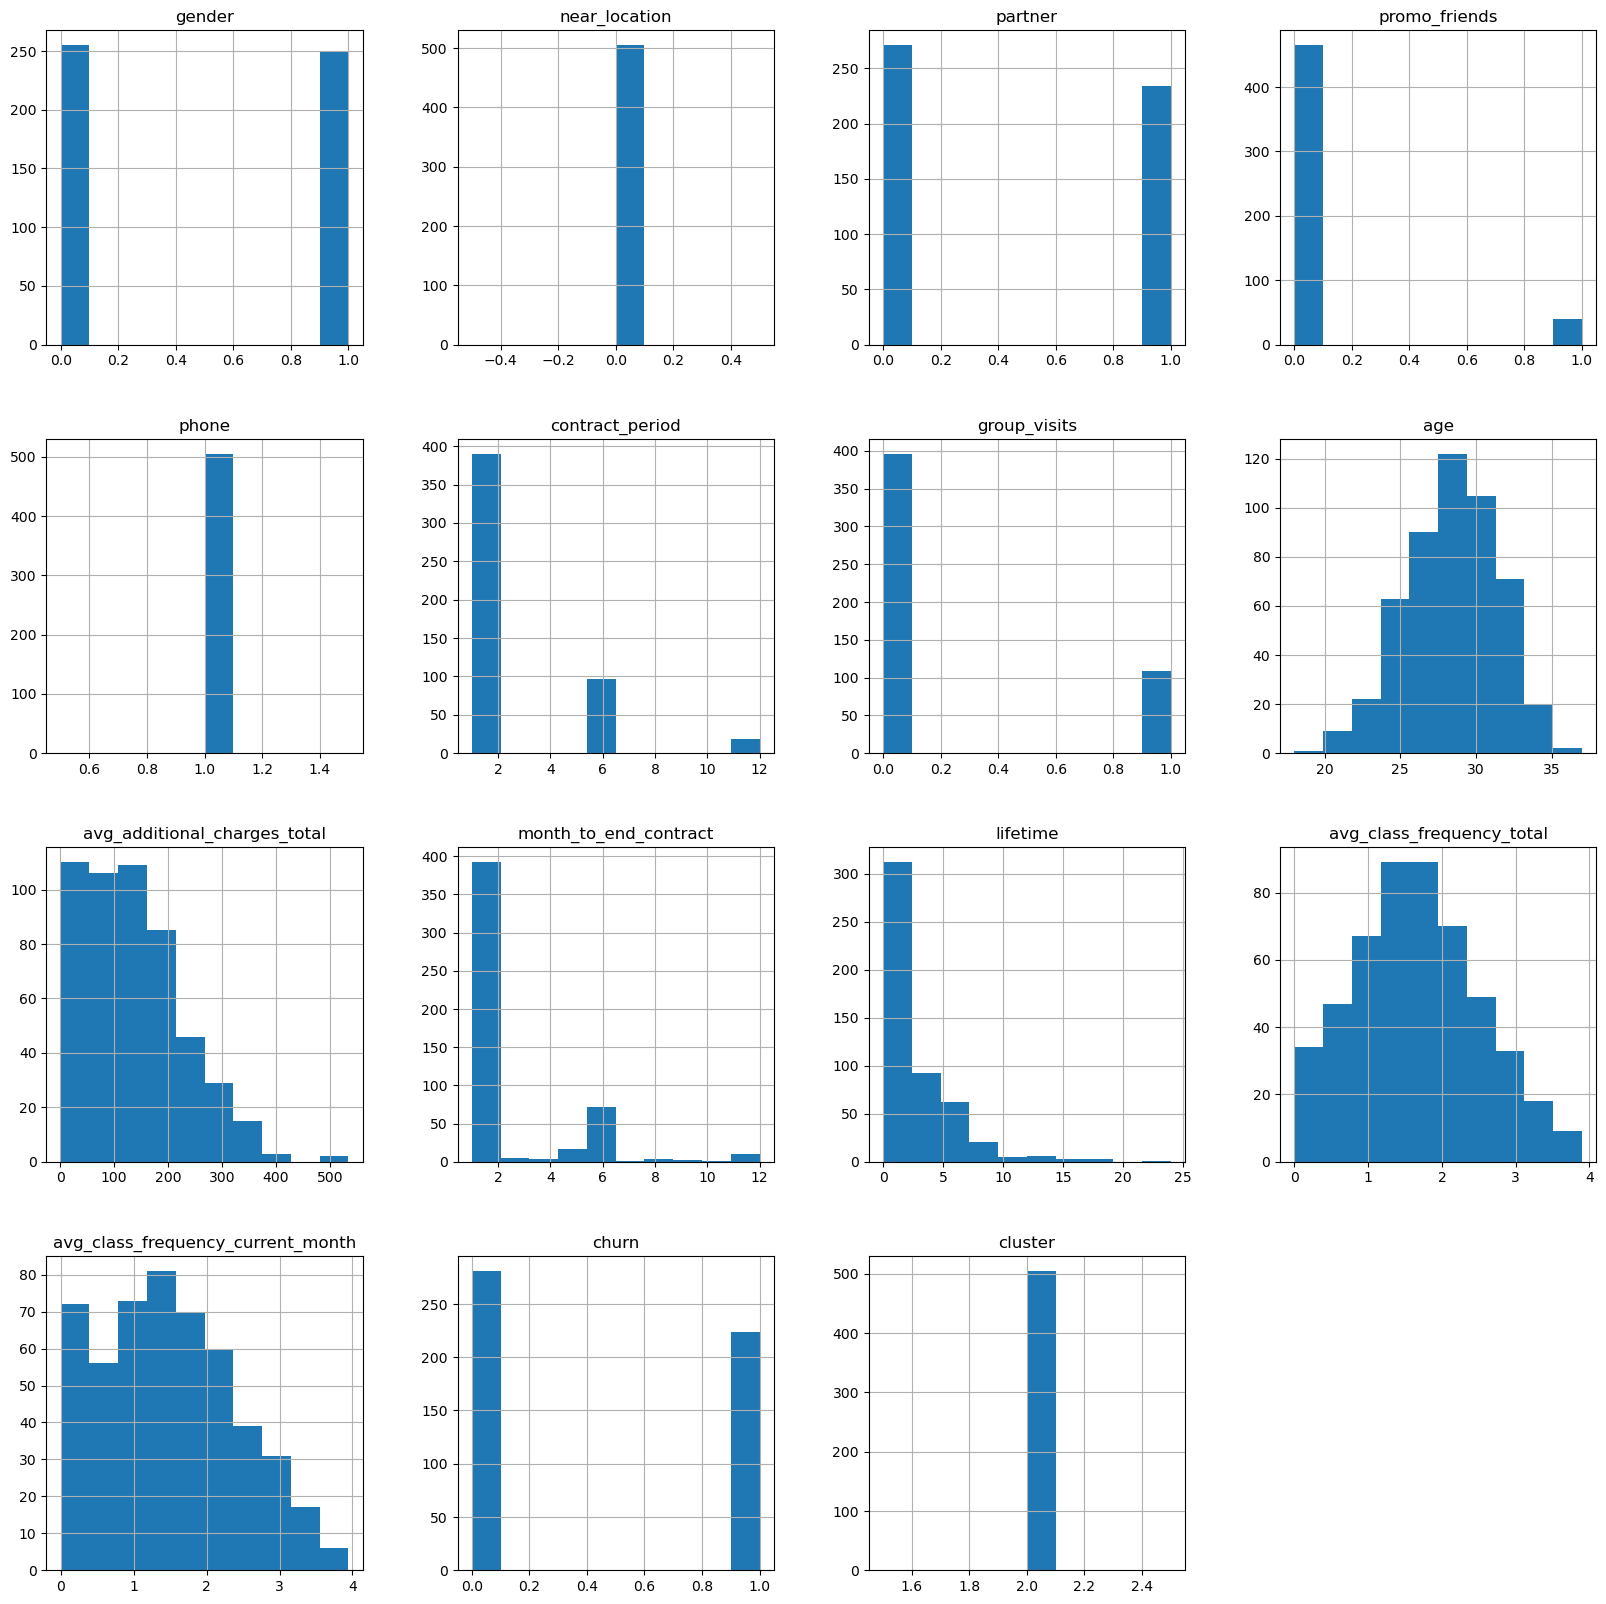

In [33]:
df.query('cluster == 2').hist(figsize=(20, 20))
plt.show()

Основные характеристики кластера:
* Примерно поровну мужчин и женщин
* Все клиенты работают и живут в другом районе
* Около 45% клиентов привлечены по партнерской программе
* Около 10% клиентов привлечены по акции "приведи друга" (не взаимоисключающе с предыдущим пунктом)
* У всех клиентов есть информация о номере телефона
* Абонементы клиентов со сроками от 1 до 6 месяцев (изредка до 12 месяцев)
* Около 75% не ходят на групповые занятия
* Возраст от 20 до 38 лет (самый распространенный - промежуток от 25 до 30)
* Траты на дополнительные услуги - от 0 до 150 денег
* Остается от 1 до 6 месяцев до окончания срока абонемента
* Привлечены в клуб менее 3 месяцев назад
* В целом посещают клуб от 1 до 1.5 раз в месяц
* Отток на уровне 40-45%

Этот кластер - частично антипод Кластера 2. Также молодые люди, но ходящие в зал реже, привлеченные недавно. Есть вероятность, что они могли найти клуб сами по рекламе, или иным способом, и взяли абонемент "на попробовать". Ввиду того, что зал не рядом с домом - скорее всего склонны переставать ходить именно по этой причине.

**Кластер 4**

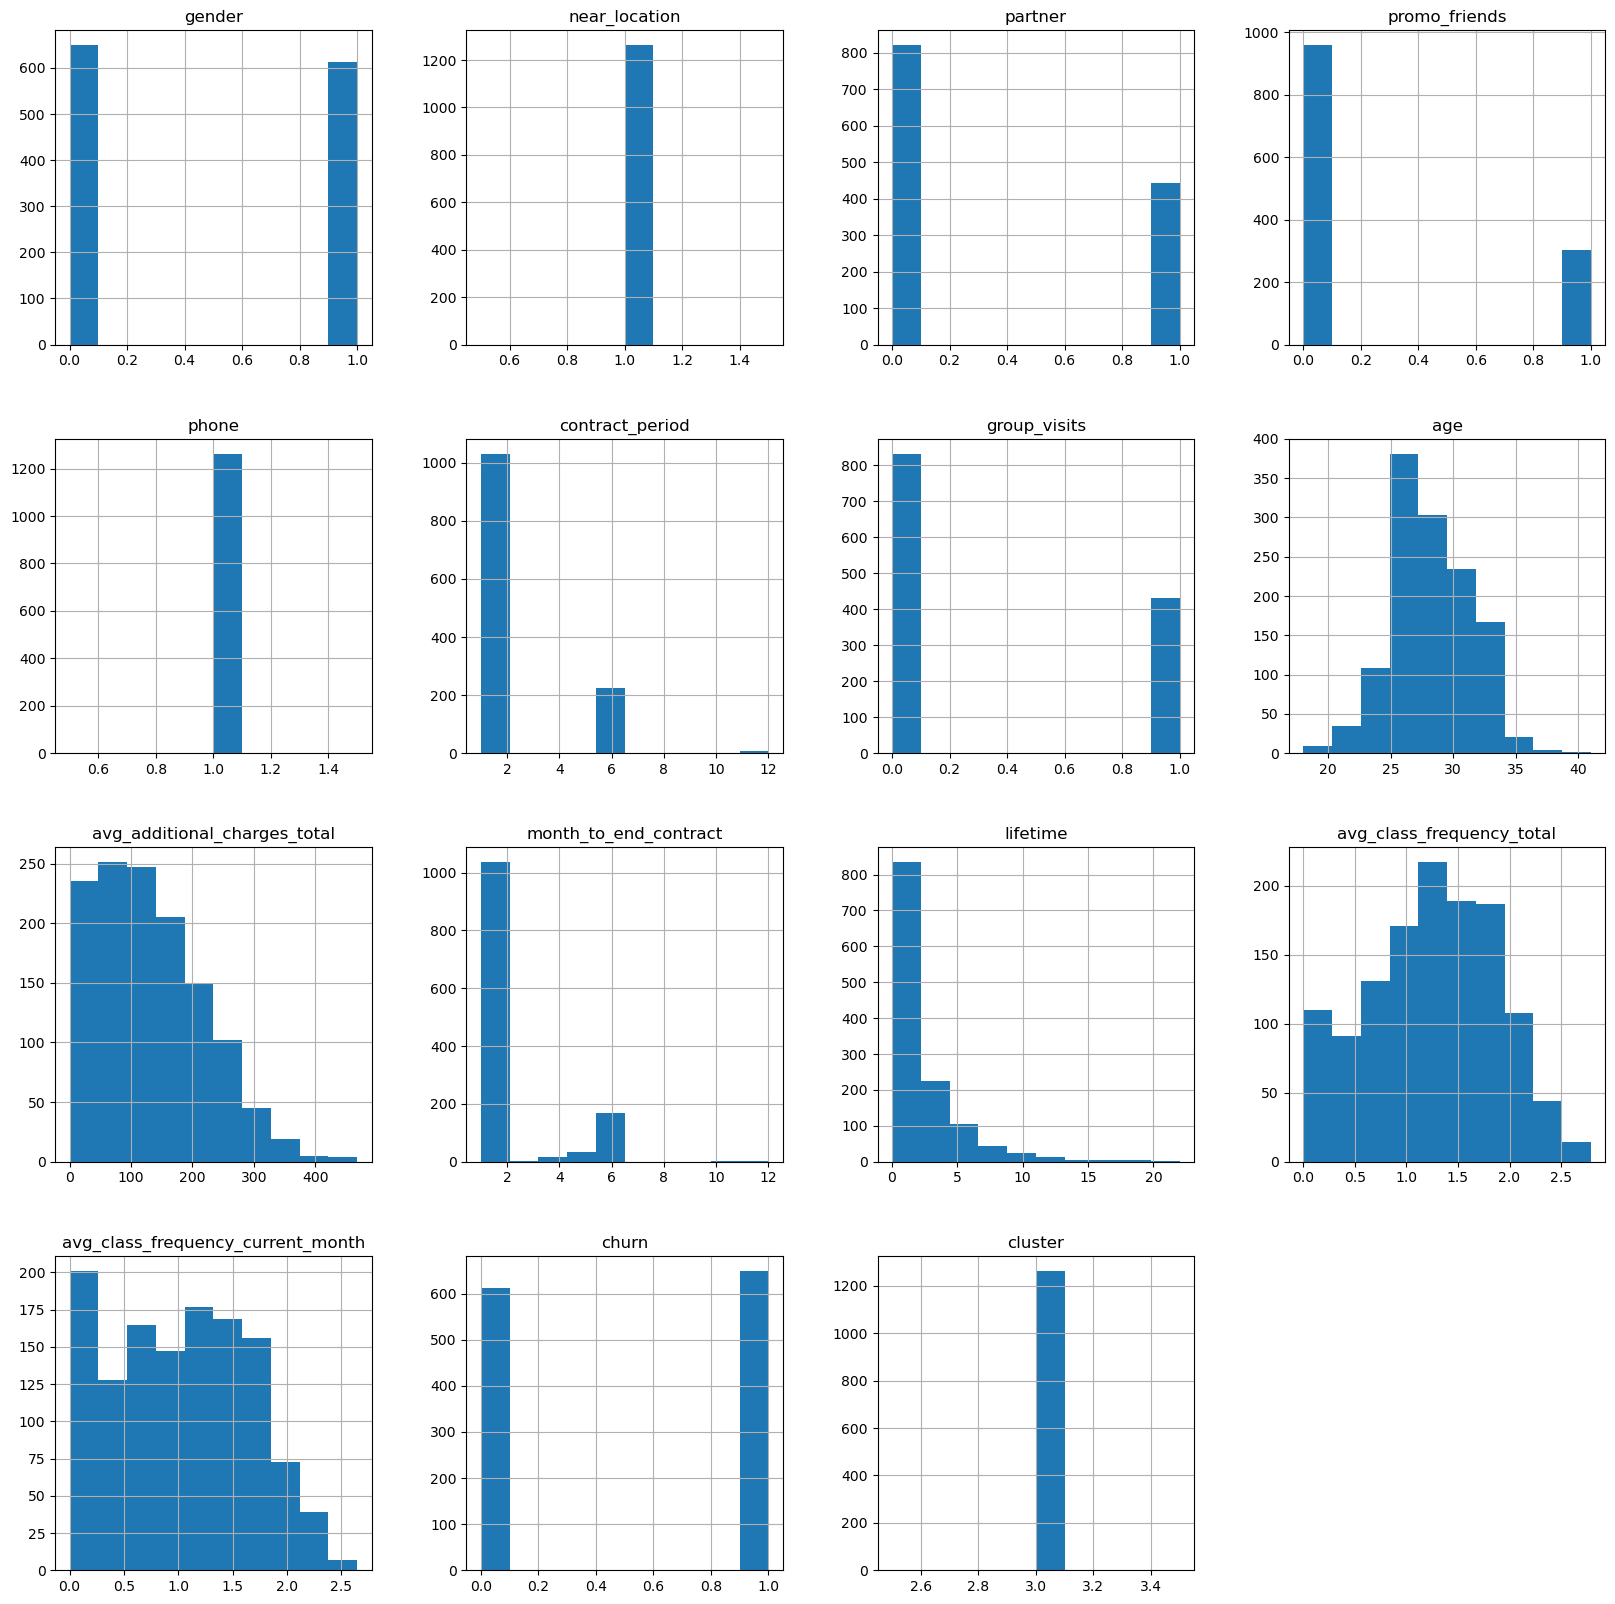

In [34]:
df.query('cluster == 3').hist(figsize=(20, 20))
plt.show()

Основные характеристики кластера:
* Примерно поровну мужчин и женщин
* Все работают или живут рядом с клубом
* Около 33% клиентов привлечены по партнерской программе
* Около 20% клиентов привлечены по акции "приведи друга" (не взаимоисключающе с предыдущим пунктом)
* У всех клиентов есть информация о номере телефона
* Абонементы клиентов со сроками от 1 до 6 месяцев
* Около 40% ходят на групповые занятия
* Возраст от 20 до 38 лет (самый распространенный - промежуток от 25 до 28)
* Траты на дополнительные услуги - от 0 до 100 денег
* Остается от 1 до 6 месяцев до окончания срока абонемента
* Привлечены в клуб менее 3 месяцев назад
* В целом посещают клуб от 1 до 1.5 раз в месяц
* Отток около 50%

Кластер 4 очень похож на Кластер 3 с той лишь разницей, что в него включены те молодые люди, которые живут или работают в одном районе с клубом и нашли его, скорее всего, сами, либо по рекламе. Здесь также распространены месячные абонементы "на попробовать", но также и больше доля оттока. Есть вероятность, что на данных клиентов и их решение о продолжении занятий в клубе оказывают влияние иные факторы, нежели чем удаленность от дома.

**Кластер 5**

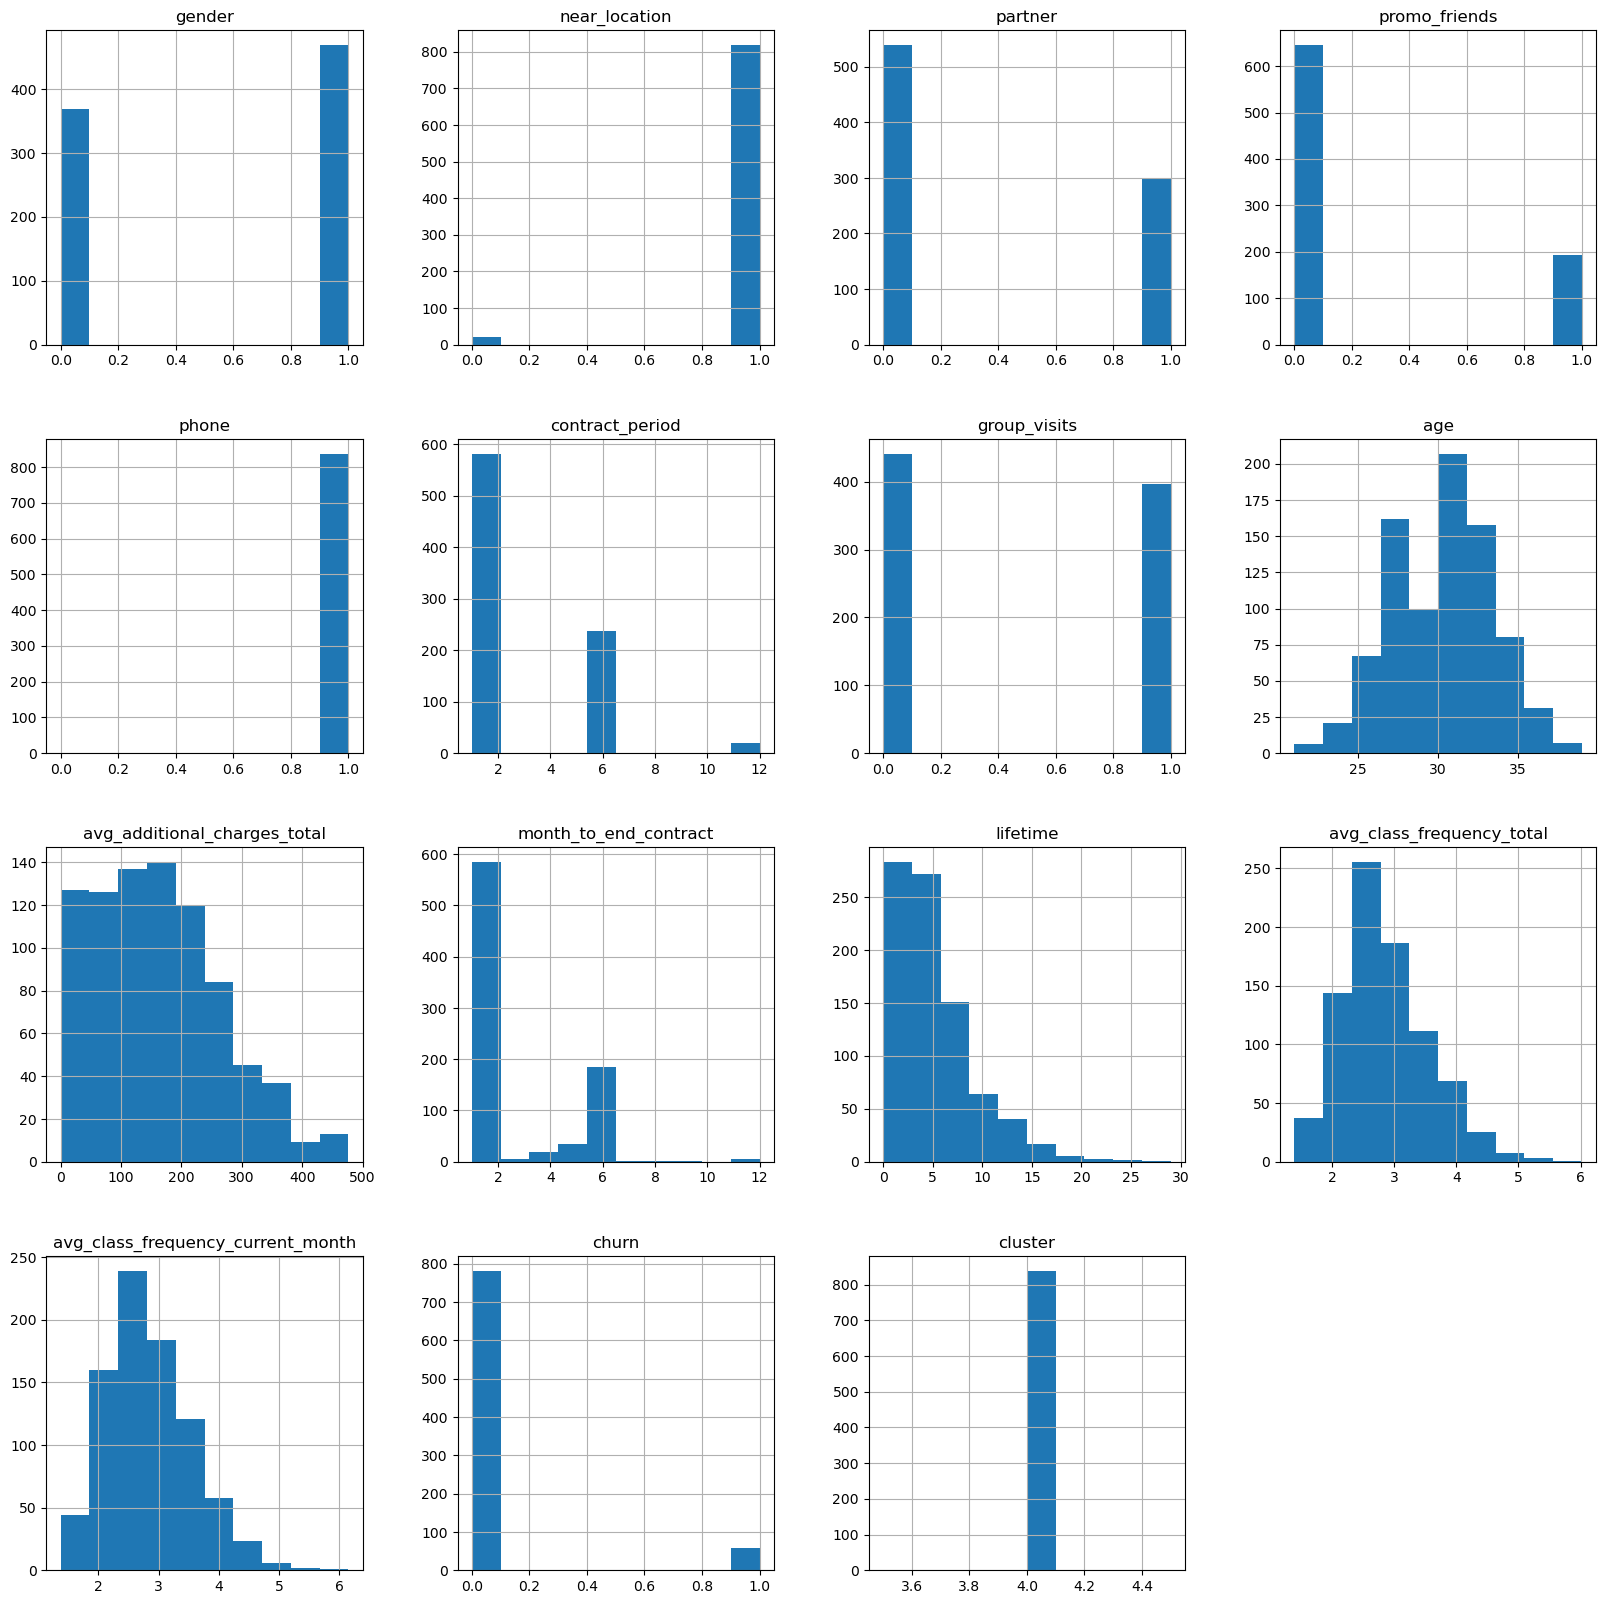

In [35]:
df.query('cluster == 4').hist(figsize=(20, 20))
plt.show()

Основные характеристики кластера:
* Клиентов одного пола чуть больше чем другого (примерно 40 на 60 процентов)
* Большинство клиентов работают или живут рядом с клубом (единичные живут и работают в другом районе)
* Около 40% клиентов привлечены по партнерской программе
* Около 25% клиентов привлечены по акции "приведи друга" (не взаимоисключающе с предыдущим пунктом)
* У всех клиентов есть информация о номере телефона
* Абонементы клиентов со сроками от 1 до 6 месяцев
* Около 45% ходят на групповые занятия
* Возраст от 20 до 38 лет (самый распространенный - 28 лет и промежуток от 30 до 35)
* Траты на дополнительные услуги - от 50 до 250 денег
* Остается от 1 до 6 месяцев до окончания срока абонемента
* Привлечены в клуб около полугода назад
* В целом посещают клуб от 2 до 3 раз в месяц
* Практически отсутствует отток (около 5-10%)

Этот кластер очень похож на кластер 1, с той лишь разницей, что здесь клиенты склонны брать короткие абонементы, но достаточно часто посещать зал. Ответственные спортсмены и ответственные взрослые, причем, скорее всего, с хорошим заработком, поскольку объем дополнительных трат достаточно высок.

### Доля оттока для кластеров

Построим таблицу, в которой будет отражаться доля оттока по каждому кластеру относительно его величины.

In [36]:
churn_table = df.groupby(['cluster']).agg({'churn':'mean'})
churn_table

churn
cluster          
0        0.027723
1        0.267532
2        0.443564
3        0.514263
4        0.068019

Поскольку отток обозначается единицей, среднее значение по каждому кластеру и будет долей оттока по кластеру (если домножить в уме на 100 - получим процентное соотношение).

Итого получаем, что минимальный отток наблюдается в 1м и 5м кластерах, а максимальные значения достигаются в 3м и 4м кластерах. Соответственно, в дальнейшей разработке стратегии взаимодействия с клиентами, необходимо будет уделить особое внимание именно этим двум кластерам, поскольку около половины пользователей в них уходят.

Второй кластер остается под вопросом, поскольку в нем уходит около четверти всех клиентов.

### Выводы

Подводя итог, можно сказать, что, благодаря кластеризации были установлены приблизительные группы пользователей, которые показывают высокую долю оттока.

Ориентируясь на предпочтения и "боли" этих групп можно будет скорректировать политику фитнес-клуба для удержания клиентской базы и мотивации к продолжению посещения зала.

## Выводы и рекомендации сервису

Благодаря проведенному анализу мы смогли определить отдельные группы риска в части оттока для сети фитнес-центров «Культурист-датасаентист».

В первую очередь это Кластеры 3 и 4 (см. описание кластеров в п.4.4), и во вторую очередь - Кластер 2.

Для того, чтобы снизить отток в кластерах возможно предложить следующие действия:

1. Для клиентов Кластера 3 предложить перевестись в фитнес-центр сети, который будет ближе к их дому или месту работы. Поскольку это единственный кластер с высоким оттоком, состоящий только из "неместных" клиентов - есть вероятность, что они уходят именно потому, что находят зал ближе к дому или работе, что позволяет им тратить меньше сил на дорогу и экономить время.
2. Провести опрос клиентов этих кластеров о том, что их не удовлетворяет в предоставляемых услугах. Как упоминалось выше, Кластер 3 может быть недоволен именно расстоянием от дома до зала. В свою очередь, Кластер 4 может быть неудовлетворен ценовой политикой, неудобным графиком работы, недостаточной полнотой услуг и т.п. По итогам опроса необходимо проработать каждую из сложных точек и найти решение, которое будет экономически выгодно сети и позитивно воспринято клиентами с позиции "нас слышат и улучшаются - мы останемся с ними".
3. Для всех трех кластеров характерен небольшой срок абонемента: можно предположить, что длительный срок будет способствовать удержанию клиента (как минимум с психологической точки зрения). Однако для повышения мотивации к приобретению длительного абонемента возможно применить "гибкую систему скидок", которая будет подразумевать экономию от длительности абонемента.
4. По Кластерам 1 и 5 видно, что отток в них минимален, а частота посещений и величина средних трат на дополнительные услуги высока. Соответственно, необходимо мотивировать остальные кластеры к увеличению частоты посещений (не забывая про упомянутые выше иные предложения), а также к приобретению дополнительных услуг. Возможно, стоит рассмотреть предоставление скидок на дополнительные услуги при определенном количестве посещений в месяц, или при приобретении долгосрочного абонемента.
5. В связке со всеми вышеописанными предложениями также возможно для Кластера 2 одновременно повысить "заполняемость" анкет и уменьшить отток, предложив за внесение в анкету телефонного номера временную скидку на дополнительные услуги (что даст небольшой прирост в средних тратах и, скорее всего, очень немного скажется на оттоке), либо на долгосрочные абонементы (этот шаг, скорее всего, увеличит количество долгих абонементов и уменьшит отток, поскольку будет играть психологический фактор).